<a href="https://colab.research.google.com/github/sj19330/Counter-app/blob/master/thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('thesis')
jovian.set_colab_id('1cPWBqPl-15bVj0slcR7FX1LnCLDd3gdC')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# Thesis

Use the "Run" button to execute the code.

In [ ]:
!pip install jovian --upgrade --quiet

# imports

In [ ]:
import jovian
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random as r
import math
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split




# commit

In [ ]:
# Execute this to save new versions of the notebook
jovian.commit(project="thesis")

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.com/ ):
API KEY:


Abort: ignored

# DATA

## Device functions

In [ ]:
def getDevice():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def toDevice(data, device):
    if isinstance(data, (list, tuple)):
        return[toDevice(x, device) for x in data]
    return data.to(device, non_blocking = True)

device = getDevice()
device.type == 'cuda'


False

## Functions for creating data

### functions for each individual subject

In [ ]:
def generateContrastsAndPerceptions(s_values, testLen, noise):  # generates a tensor simulating what is shown on screen for the length of the test
    SS = torch.empty(testLen,1)
    perceived = torch.empty(testLen, 2)
    labels = torch.empty(testLen, 1)
    std = noise ** 2 / 2  # standard deviation

    for index in range(testLen):
        s = s_values[r.randint(0, 3)]  # randomly decide a values for s from the possible values given
        label = r.randint(1, 2)  # randomly decide what interval the target will be in
        labels[index] = torch.tensor([[label]])  # log which interval the target is in for this round

        targetValue = np.random.normal((s), std)  # generate the sensory signals perceived by the test subjects
        standardValue = np.random.normal(0, std)
        SS[index] = torch.tensor([[s]])
        if label == 1:  # log the Sensory signals showed on screen for this round and what is perceived

            perceived[index] = torch.tensor([targetValue, standardValue])
        elif label == 2:
            perceived[index] = torch.tensor([standardValue, targetValue])
        else:
            print("ERROR: label is out of range")

    return SS, perceived, labels


# gets the decision variables according to the difference model
def getDifferenceModelDVs(inputSignals, dataLen):
    diffModelDVs = torch.empty((dataLen, 1))
    for index in range(dataLen):
        diffModelDVs[index] = torch.tensor([inputSignals[index][1].item() - inputSignals[index][0].item()])
    return diffModelDVs


# gets the decision variables according to the max model (same as difference model)
def getMaxModelDVs(inputSignals, dataLen):
    return getDifferenceModelDVs(inputSignals, dataLen)


# function that returns the probability density of a normal distribution according to the mean, _____ , and the x value
# probability density function of a normal distribution
def PDFoN(x, mean, sigma):
    xmms = ((x - mean) ** 2)
    tss = 2 * (sigma ** 2)
    exp = -(xmms / tss)
    tpi = 2 * math.pi
    srtpi = math.sqrt(tpi)
    c = sigma * srtpi
    coef = 1 / c
    e = math.e
    return coef * (e ** exp)


def logit(x):
    if(x == 1):
        x = 0.9999999999999999
    z = x/(1-x)
    z = math.log(z)
    return z

# function that
def bayesianMethod(inputSignals, noise, s_values, decision):
    std = noise ** 2 / 2
    s_values = torch.tensor([0.,0.015,0.035, 0.07,0.15])
    top = 0
    bottom = 0
    if decision == 1:
        for i in range(len(s_values)):
            thisTop = PDFoN(inputSignals[0].item(), s_values[i].item(), std) * PDFoN(inputSignals[1].item(), 0, std)
            thisBottom = thisTop + PDFoN(inputSignals[0].item(), 0, std) * PDFoN(inputSignals[1].item(), s_values[i].item(),std)
            top = top + thisTop
            bottom = bottom + thisBottom
    elif decision == 2:
        for i in range(len(s_values)):
            thisTop = PDFoN(inputSignals[0].item(), 0, std) * PDFoN(inputSignals[1].item(), s_values[i].item(), std)
            thisBottom = thisTop + PDFoN(inputSignals[0].item(), s_values[i].item(), std) * PDFoN(inputSignals[1].item(), 0,std)
            top = top + thisTop
            bottom = bottom + thisBottom
    val = logit(top/bottom)/30
    return val



def getBayesianModelDVs(inputSignals, dataLen, noise, s_values):
    bayesianModelDVs = torch.empty(dataLen)
    for index in range(dataLen):
        bayesianModelDVs[index] = bayesianMethod(inputSignals[index], noise, s_values, 2)
    return bayesianModelDVs

# takes in the decision variables and boundary and returns a list of what decisions would be made accordingly
def getDecisions(decisionVariable, dataLen, decisionBoundary):
    decisions = torch.empty((dataLen, 1))
    for index in range(dataLen):
        if decisionVariable[index] > decisionBoundary:
            decisions[index] = torch.tensor([[2]])
        else:
            decisions[index] = torch.tensor([[1]])

    return decisions

# takes in the sensory signals and decisions the diff model would make and retuns the confidence values according to the
def getDiffModelCVs(sensorySignals, diffModelDecisions, dataLen):
    diffModelCVs = torch.empty(dataLen)
    for index in range(dataLen):
        if diffModelDecisions[index] == 1:
            diffModelCVs[index] = sensorySignals[index][0] - sensorySignals[index][1]
        elif diffModelDecisions[index] == 2:
            diffModelCVs[index] = sensorySignals[index][1] - sensorySignals[index][0]
        else:
            print("error")
    return diffModelCVs

# takes in the sensory signals and decisions the max model would make and retuns the confidence values according to the
def getMaxModelCVs(sensorySignals, maxModelDecisions, dataLen):
    maxModelCVs = torch.empty(dataLen)
    for index in range(dataLen):
        if maxModelDecisions[index] == 1:
            maxModelCVs[index] = sensorySignals[index][0]
        elif maxModelDecisions[index] == 2:
            maxModelCVs[index] = sensorySignals[index][1]
        else:
            print("error")
    return maxModelCVs

# takes in the sensory signals and decisions the bayesian model would make and retuns the confidence values according to the
def getBayesianModelCVs(sensorySignals, bayesianModelDecisions, noise, s_values, dataLen):
    bayesianModelCVs = torch.empty(dataLen)
    for i in range(dataLen):
        bayesianModelCVs[i] = bayesianMethod(sensorySignals[i], noise, s_values, bayesianModelDecisions[i])
    return bayesianModelCVs

# takes in the confidence variables and boundaries and returns a list of what confidence reports would be made accordingly
def getConfidences(confidenceValues, ConfidenceBoundaries):
    confidenceDecisions = torch.empty(len(confidenceValues))
    for i in range(len(confidenceValues)):
        CD = -1
        CV = confidenceValues[i]

        if CV <= ConfidenceBoundaries[0]:
            CD = 1
        elif ConfidenceBoundaries[0] < CV <= ConfidenceBoundaries[1]:
            CD = 2
        elif ConfidenceBoundaries[1] < CV <= ConfidenceBoundaries[2]:
            CD = 3
        elif ConfidenceBoundaries[2] < CV <= ConfidenceBoundaries[3]:
            CD = 4
        elif ConfidenceBoundaries[3] < CV <= ConfidenceBoundaries[4]:
            CD = 5
        elif ConfidenceBoundaries[4] < CV:
            CD = 6

        if CD == -1:
            print("Error: confidence decision is out of range", CV)
        else:
            confidenceDecisions[i] = CD

    return confidenceDecisions

#for finding out how many the subject would judge correctly with the ammount of noise in the model
def printCorrectness(dataset, labels):
    i = 0
    for data, label in zip(dataset, labels):
        if data[0].item() < data[1].item():
            if label == 1:
                i = i + 1
        else:
            if label == 2:
                i = i + 1
    print("correctness : ", 1 - i / len(dataset))


def getSubjectResults(s_values, noise, testLen, decisionBoundries, confidenceBoundaries):
#     get a list of what was shown on screen, what the subject perceived
    sensory_signals, perceived, labels = generateContrastsAndPerceptions(s_values, testLen, noise)

#     calculate what the decision variables are for each of the different models
    diffModelDVars = getDifferenceModelDVs(perceived, testLen)
    maxModelDVars = getMaxModelDVs(perceived, testLen)
    bayesianModelDVars = getBayesianModelDVs(perceived, testLen, noise, s_values)

#     split the decision boundaries into different variables
    diffModelDB, maxModelDB, bayesianModelDB = decisionBoundries

#     get what the different models decisions will be for each test
    diffModelDecisions = getDecisions(diffModelDVars, testLen, diffModelDB)
    maxModelDecisions = getDecisions(maxModelDVars, testLen, maxModelDB)
    bayesianModelDecisions = getDecisions(bayesianModelDVars, testLen, bayesianModelDB)

#     get the confidence variables for the different models for each test
    diffModelCVs = getDiffModelCVs(perceived, diffModelDecisions, testLen)
    maxModelCVs = getMaxModelCVs(perceived, maxModelDecisions, testLen)
    bayesianModelCVs = getBayesianModelCVs(perceived, bayesianModelDecisions, noise, s_values, testLen)

#     split the confidence boundaries into different variables
    diffModelCBs, maxModelCBs, bayesianModelCBs = confidenceBoundaries

#     get what the confidences for each model would be with the given variables and boundaries
    diffModelConfidences = getConfidences(diffModelCVs, diffModelCBs)
    maxModelConfidences = getConfidences(maxModelCVs, maxModelCBs)
    bayesianModelConfidences = getConfidences(bayesianModelCVs, bayesianModelCBs)

#     put the decisions and confidences for the models into a singel variable to be returned
    decisions = diffModelDecisions, maxModelDecisions, bayesianModelDecisions
    confidences = diffModelConfidences, maxModelConfidences, bayesianModelConfidences

    return sensory_signals, labels, decisions, confidences



def getSamples(s_values, noise, dataLen):
    _, perceived, labels = generateContrastsAndPerceptions(s_values, dataLen, noise)

#     calculate what the decision variables are for each of the different models
    diffModelDVars = getDifferenceModelDVs(perceived, dataLen)
    maxModelDVars = getMaxModelDVs(perceived, dataLen)
    bayesianModelDVars = getBayesianModelDVs(perceived, dataLen, noise, s_values)

    diffModelDB = 0
    maxModelDB = 0
    bayesianModelDB = 0

    diffModelDecisions = getDecisions(diffModelDVars, dataLen, diffModelDB)
    maxModelDecisions = getDecisions(maxModelDVars, dataLen, maxModelDB)
    bayesianModelDecisions = getDecisions(bayesianModelDVars, dataLen, bayesianModelDB)

    diffModelCVs = getDiffModelCVs(perceived, diffModelDecisions, dataLen)
    maxModelCVs = getMaxModelCVs(perceived, maxModelDecisions, dataLen)
    bayesianModelCVs = getBayesianModelCVs(perceived, bayesianModelDecisions, noise, s_values, dataLen)

    DVs = diffModelDVars, maxModelDVars, bayesianModelDVars
    CVs = diffModelCVs, maxModelCVs, bayesianModelCVs

    return DVs, CVs

def getDVSamples(s_values, noise, dataLen):
    sensory_signals, perceived, labels = generateContrastsAndPerceptions(s_values, dataLen, noise)

#     calculate what the decision variables are for each of the different models
    diffModelDVars = getDifferenceModelDVs(perceived, dataLen)
    maxModelDVars = getMaxModelDVs(perceived, dataLen)
    bayesianModelDVars = getBayesianModelDVs(perceived, dataLen, noise, s_values)

    DVs = diffModelDVars, maxModelDVars, bayesianModelDVars
    return DVs, perceived

def getCVSamples(s_values, noise, dataLen, diffModelDB, maxModelDB, bayesianModelDB, perceived):

    diffModelDecisions = getDecisions(diffModelDVars, dataLen, diffModelDB)
    maxModelDecisions = getDecisions(maxModelDVars, dataLen, maxModelDB)
    bayesianModelDecisions = getDecisions(bayesianModelDVars, dataLen, bayesianModelDB)

    diffModelCVs = getDiffModelCVs(perceived, diffModelDecisions, diffModelDB, dataLen)
    maxModelCVs = getMaxModelCVs(perceived, maxModelDecisions, dataLen)
    bayesianModelCVs = getBayesianModelCVs(perceived, bayesianModelDecisions, noise, s_values, dataLen)

    DVs = diffModelDVars, maxModelDVars, bayesianModelDVars
    CVs = diffModelCVs, maxModelCVs, bayesianModelCVs


### functions for getting results from multiple subjects

In [ ]:

def getDecisionBoundaries():       #generates some believable decision boundaries for each of the models
    diffModelDB = torch.normal(torch.tensor(0.), torch.tensor(0.02))
    maxModelDB = torch.normal(torch.tensor(0.), torch.tensor(0.02))
    bayesianModelDB = torch.normal(torch.tensor(0.), torch.tensor(0.015))
    return torch.tensor([[diffModelDB], [maxModelDB], [bayesianModelDB]])

def helper(lower_limit, upper_limit):
    a = np.random.uniform(lower_limit,upper_limit,(5))
    a.sort()
    return a

def getConfidenceBoundaries():   #generates some confidence boundaries for each of the models in the ranges of the confidence variables
    diffModelCB = helper(0, 0.21)
    maxModelCB = helper(0, 0.21)
    bayesianCB = helper(0, 1)
    return torch.tensor([diffModelCB, maxModelCB, bayesianCB])


def getDecisionProportions(decisions, testLen):     #returns a tensor whos first value is the proportion on decisions for interval one and second is the proportion for interval 2
    ones = torch.sum(decisions[:, 0] == 1) / testLen
    twos = 1 - ones
    return torch.tensor([ones, twos])

def getConfidenceProportions(confidences, testLen):   # like above returns a tensor which has the proportions of how much each confidence report was chosen
    ones = torch.sum(confidences[:] == 1) / testLen
    twos = torch.sum(confidences[:] == 2) / testLen
    threes = torch.sum(confidences[:] == 3) / testLen
    fours = torch.sum(confidences[:] == 4) / testLen
    fives = torch.sum(confidences[:] == 5) / testLen
    sixes = torch.sum(confidences[:] == 6) / testLen
    return torch.tensor([ones, twos, threes, fours, fives, sixes])

def getDataForModel(dataLen, testLen, show, s_values, noise):

    # prepare
    decisionBoundaries = torch.empty(dataLen, 3, 1) # getting tensor ready to be filled
    confidenceBoundaries = torch.empty(dataLen, 3, 5) # getting tensor ready to be filled
    DMDPs = torch.empty(dataLen, 2)
    MMDPs = torch.empty(dataLen, 2)
    BMDPs = torch.empty(dataLen, 2)
    DMCPs = torch.empty(dataLen, 6)
    MMCPs = torch.empty(dataLen, 6)
    BMCPs = torch.empty(dataLen, 6)

    for subject in range(dataLen):
        # make the boundries change arround
        # getBoundaries
        DBs = getDecisionBoundaries()
        CBs = getConfidenceBoundaries()
#         record decision and confidence boundaries for this subjet
        decisionBoundaries[subject] = DBs # add
        confidenceBoundaries[subject] = CBs

        # get the results from the subjects trials
        _, _, decisions, confidences = getSubjectResults(s_values, noise, testLen, DBs, CBs)

#         split the decisions and confidence ratings and log them for each model
        diffModelDecisions, maxModelDecisions, bayesianModelDecisions = decisions
        diffModelConfidences, maxModelConfidences, bayesianModelConfidences = confidences

        DMDPs[subject] = getDecisionProportions(diffModelDecisions, testLen)
        MMDPs[subject] = getDecisionProportions(maxModelDecisions, testLen)
        BMDPs[subject] = getDecisionProportions(bayesianModelDecisions, testLen)

        DMCPs[subject] = getConfidenceProportions(diffModelConfidences, testLen)
        MMCPs[subject] = getConfidenceProportions(maxModelConfidences, testLen)
        BMCPs[subject] = getConfidenceProportions(bayesianModelConfidences, testLen)

        if (((subject*100)/dataLen)%10 == 0):
            print(subject+1, "/", dataLen, "made")
    print("done")

    return DMDPs, MMDPs, BMDPs, DMCPs, MMCPs, BMCPs, decisionBoundaries, confidenceBoundaries


def getDecisionProportions2(decisions, SS):
    decisions1 = (SS == 0.015)
    num = decisions1.sum()
    decisions1 = decisions*decisions1
    decisions1Proportions = getDecisionProportions(decisions1, num)
    decisions2 = (SS == 0.035)
    num = decisions2.sum()
    decisions2 = decisions*decisions2
    decisions2Proportions = getDecisionProportions(decisions2, num)
    decisions3 = (SS == 0.07)
    num = decisions3.sum()
    decisions3 = decisions*decisions3
    decisions3Proportions = getDecisionProportions(decisions3, num)
    decisions4 = (SS == 0.15)
    num = decisions4.sum()
    decisions4 = decisions*decisions4
    decisions4Proportions = getDecisionProportions(decisions4, num)
    decisionProportions = decisions1Proportions, decisions2Proportions, decisions3Proportions, decisions4Proportions
    return decisionProportions



def getConfidenceProportions2(confidences, SS):
    confidences = confidences.reshape(-1,1)
    confidences1 = (SS == 0.015)
    num = confidences1.sum()
    confidences1 = confidences*confidences1
    confidences1Proportions = getConfidenceProportions(confidences1, num)
    confidences2 = (SS == 0.035)
    num = confidences2.sum()
    confidences2 = confidences*confidences2
    confidences2Proportions = getConfidenceProportions(confidences2, num)
    confidences3 = (SS == 0.07)
    num = confidences3.sum()
    confidences3 = confidences*confidences3
    confidences3Proportions = getConfidenceProportions(confidences3, num)
    confidences4 = (SS == 0.15)
    num = confidences4.sum()
    confidences4 = confidences*confidences4
    confidences4Proportions = getConfidenceProportions(confidences4, num)
    confidenceProportions = confidences1Proportions, confidences2Proportions, confidences3Proportions, confidences4Proportions
    return confidenceProportions

def getDataForModel2(datalen, testLen, show, s_values, noise):
    # prepare
    decisionBoundaries = torch.empty(dataLen, 3, 1) # getting tensor ready to be filled
    confidenceBoundaries = torch.empty(dataLen, 3, 5) # getting tensor ready to be filled
    DMDPs = torch.empty(dataLen, 4, 2)
    MMDPs = torch.empty(dataLen, 4, 2)
    BMDPs = torch.empty(dataLen, 4, 2)
    DMCPs = torch.empty(dataLen, 4, 6)
    MMCPs = torch.empty(dataLen, 4, 6)
    BMCPs = torch.empty(dataLen, 4, 6)

    for subject in range(dataLen):
        # make the boundries change arround
        # getBoundaries
        DBs = getDecisionBoundaries()
        CBs = getConfidenceBoundaries()
#         record decision and confidence boundaries for this subjet
        decisionBoundaries[subject] = DBs # add
        confidenceBoundaries[subject] = CBs

        # get the results from the subjects trials
        SS, _, decisions, confidences = getSubjectResults(s_values, noise, testLen, DBs, CBs)

#         split the decisions and confidence ratings and log them for each model
        diffModelDecisions, maxModelDecisions, bayesianModelDecisions = decisions
        diffModelConfidences, maxModelConfidences, bayesianModelConfidences = confidences

        DMDPs[subject][0], DMDPs[subject][1], DMDPs[subject][2], DMDPs[subject][3] = getDecisionProportions2(diffModelDecisions, SS)
        MMDPs[subject][0], MMDPs[subject][1], MMDPs[subject][2], MMDPs[subject][3] = getDecisionProportions2(maxModelDecisions, SS)
        BMDPs[subject][0], BMDPs[subject][1], BMDPs[subject][2], BMDPs[subject][3] = getDecisionProportions2(bayesianModelDecisions, SS)

        DMCPs[subject][0], DMCPs[subject][1], DMCPs[subject][2], DMCPs[subject][3]  = getConfidenceProportions2(diffModelConfidences, SS)
        MMCPs[subject][0], MMCPs[subject][1], MMCPs[subject][2], MMCPs[subject][3] = getConfidenceProportions2(maxModelConfidences, SS)
        BMCPs[subject][0], BMCPs[subject][1], BMCPs[subject][2], BMCPs[subject][3], = getConfidenceProportions2(bayesianModelConfidences, SS)

        if (((subject*100)/dataLen)%10 == 0):
            print(subject+1, "/", dataLen, "made")
    print("done")

    return DMDPs, MMDPs, BMDPs, DMCPs, MMCPs, BMCPs, decisionBoundaries, confidenceBoundaries

In [ ]:
f = torch.tensor([[0.15], [0.015], [0.15], [0.015], [0.035], [0.015],[0.035]])
s = torch.tensor([[1], [3],[2], [1], [2], [2], [1]])
getConfidenceProportions2(s, f)


(tensor([0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000]),
 tensor([0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000]),
 tensor([nan, nan, nan, nan, nan, nan]),
 tensor([0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000]))

## split data function

In [ ]:
def split(dataset, proportion_split):

    batch1, batch2 = random_split(dataset, [int(len(dataset)*(proportion_split)), int(len(dataset)*(1-proportion_split))])
    return batch1, batch2

# nn model

In [ ]:
# defines a class for a neural network with one hidden layer for predicting the decisions and confidences from the proportions
class nnModel(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        self.layer1 = nn.Linear(in_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, out_size)

    def forward(self, inputs):
        firstLayerOutput = self.layer1(inputs)
        firstLayerOutput = F.relu(firstLayerOutput)
        output = self.layer2(firstLayerOutput)
        return output

    def train_step(self, inputs, labels):
        predictions = self(inputs)
        loss = F.mse_loss(predictions, labels)
        return loss

    def val_step(self, batch):
        inputs, labels = batch
        predictions = self(inputs)
        loss = F.mse_loss(predictions, labels)
        return loss



In [ ]:
# function which trains a model given to it with the according number of epochs, loss function, optimiser, train dataloader and validation data loader
def fit(num_epochs, model, loss_fn, opt, train_dl, val_dl):
    losses = []
    for epoch in range(num_epochs):
        for proportions, labels in train_dl:
            loss = model.train_step(proportions, labels)
            loss.backward()
            opt.step()
            opt.zero_grad()

        val_loss = 0
        for batch in val_dl:
            val_loss = val_loss + model.val_step(batch)

        losses.append(val_loss.item())
        if (epoch+1) % 100 == 0:
            print('Epoch [{}/{}], validation Loss: {:.9f}'.format(epoch, num_epochs, val_loss))
    print("fitted")
    return losses





## fit for decisions

In [ ]:
#for a given batch size, train dataset and number of epochs, this function creates a model, fits it and returns the model and the losses that it makes as it is trained(for decision)
def createAndFitD(num_epochs, batch_size, train_ds):
    val_ds, train_ds = split(train_ds, 0.25)
    train_dl = DataLoader(train_ds, batch_size, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size)
    model = nnModel(2, 100, 1)
    loss_fn = F.mse_loss
    opt = torch.optim.SGD(model.parameters(), lr=1e-1)
    losses = fit(num_epochs, model, loss_fn, opt, train_dl, val_dl)
    return model, losses

## fit for confidences


In [ ]:
# this function is for adding a decision boundary to the front of a torch tensor. this is for input to the confidence model
def addDBtoinput(DBs, CPs):
    inputs = torch.empty(len(DBs),7)
    inputs[:,0] = DBs[:,0]
    inputs[:,1:] = CPs[:,:]
    return inputs
#same as the above create and fit but for confidences
def createAndFitC(num_epochs, batch_size, train_ds):
    val_ds, train_ds = split(train_ds, 0.25)
    train_dl = DataLoader(train_ds, batch_size, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size)
    model = nnModel(7, 100, 5)
    loss_fn = F.mse_loss
    opt = torch.optim.SGD(model.parameters(), lr=1e-1)
    losses = fit(num_epochs, model, loss_fn, opt, train_dl, val_dl)
    return model, losses




## fit for joint nn

In [ ]:
def combineProportions(DPs, CPs):
    inputs = torch.empty(len(DPs),8)
    inputs[:,0:2] = DPs[:,:]
    inputs[:,2:] = CPs[:,:]
    return inputs

def combineBoundaries(DBs, CBs):
    labels = torch.empty(len(DBs),6)
    labels[:,0] = DBs[:,0]
    labels[:,1:] = CBs[:,:]
    return labels

def createAndFitJ(num_epochs, batch_size, train_ds):
    val_ds, train_ds = split(train_ds, 0.25)
    train_dl = DataLoader(train_ds, batch_size, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size)
    model = nnModel(8, 200, 6)
    loss_fn = F.mse_loss
    opt = torch.optim.SGD(model.parameters(), lr=1e-1)
    losses = fit(num_epochs, model, loss_fn, opt, train_dl, val_dl)
    return model, losses


## fit for complex decisions

In [ ]:
#for a given batch size, train dataset and number of epochs, this function creates a model, fits it and returns the model and the losses that it makes as it is trained(for decision)
def createAndFitDC(num_epochs, batch_size, train_ds):
    val_ds, train_ds = split(train_ds, 0.25)
    train_dl = DataLoader(train_ds, batch_size, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size)
    model = nnModel(8, 100, 1)
    loss_fn = F.mse_loss
    opt = torch.optim.SGD(model.parameters(), lr=1e-1)
    losses = fit(num_epochs, model, loss_fn, opt, train_dl, val_dl)
    return model, losses

fit for complex confidences

In [ ]:
def createAndFitCC(num_epochs, batch_size, train_ds):
    val_ds, train_ds = split(train_ds, 0.25)
    train_dl = DataLoader(train_ds, batch_size, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size)
    model = nnModel(24, 100, 5)
    loss_fn = F.mse_loss
    opt = torch.optim.SGD(model.parameters(), lr=1e-1)
    losses = fit(num_epochs, model, loss_fn, opt, train_dl, val_dl)
    return model, losses

# proportions method

In [ ]:
#changes all the samples into a sorted list
def reshapeSort(diffDVsamples, maxDVsamples, bayesianDVsamples):

    diffDVsamples = diffDVsamples.reshape(-1, samples_len)[0]
    maxDVsamples = maxDVsamples.reshape(-1, samples_len)[0]
    bayesianDVsamples = bayesianDVsamples.reshape(-1, samples_len)[0]

    diffDVsamples, _ = torch.sort(diffDVsamples)
    maxDVsamples, _ = torch.sort(maxDVsamples)
    bayesianDVsamples, _ = torch.sort(bayesianDVsamples)

    return diffDVsamples, maxDVsamples, bayesianDVsamples

# given the confidence poportions, and confidence values this finds where the confidence boundaries should be
def getCB(CVs, CPs, samples_len):
    ret = torch.empty(5)
    ret[0] = CVs[int(CPs[0]*samples_len)-1]
    if ret[0]<0:
        ret[0] = 0
    ret[1] = CVs[int((CPs[0]+CPs[1])*samples_len)-1]
    ret[2] = CVs[int((CPs[0]+CPs[1]+CPs[2])*samples_len)-1]
    ret[3] = CVs[int((CPs[0]+CPs[1]+CPs[2]+CPs[3])*samples_len)-1]
    ret[4] = CVs[int((CPs[0]+CPs[1]+CPs[2]+CPs[3]+CPs[4])*samples_len)-1]
    return ret



def proportions_method(s_values, noise, samples_len, DP, CP):

    sensory_signals, perceived, labels = generateContrastsAndPerceptions(s_values, samples_len, noise)

#     calculate what the decision variables are for each of the different models
    diffDVsamples = getDifferenceModelDVs(perceived, samples_len)
    maxDVsamples = getMaxModelDVs(perceived, samples_len)
    bayesianDVsamples = getBayesianModelDVs(perceived, samples_len, noise, s_values)

# sorts the decision variable samples
    dDVsamples, mDVsamples, bDVsamples = reshapeSort(diffDVsamples, maxDVsamples, bayesianDVsamples)

# finds where the decision value will be for each different model
    diffModelDB = dDVsamples[int(DP[0]*samples_len)]
    maxModelDB = mDVsamples[int(DP[0]*samples_len)]
    bayesianModelDB = bDVsamples[int(DP[0]*samples_len)]

# gets the decisions for the different models
    diffModelDecisions = getDecisions(diffDVsamples, samples_len, diffModelDB)
    maxModelDecisions = getDecisions(maxDVsamples, samples_len, maxModelDB)
    bayesianModelDecisions = getDecisions(bayesianDVsamples, samples_len, bayesianModelDB)

    # calculates the confidence variables for each model
    diffModelCVs = getDiffModelCVs(perceived, diffModelDecisions, samples_len)
    maxModelCVs = getMaxModelCVs(perceived, maxModelDecisions, samples_len)
#     bayesianModelCVs = getBayesianModelCVs(perceived, bayesianDVsamples, noise, s_values, samples_len)
    # reshapes and sorts the confidence variables
    diffModelCVs, maxModelCVs, _ =  reshapeSort(diffModelCVs, maxModelCVs, bayesianDVsamples)



#     diffModelCB = getCB(diffModelCVs)
    DCBs = getCB(diffModelCVs, CP, samples_len)
    MCBs = getCB(maxModelCVs, CP, samples_len)
    BCBs = getCB(maxModelCVs, CP, samples_len)#change when bayesian is working
    CBs = DCBs, MCBs, BCBs
    DBs = diffModelDB, maxModelDB, bayesianModelDB

    return DBs, CBs

# does the same as reshape and sort but for only one tensor of decision variable samples
def reshapeSort2(DVsamples):

    DVsamples = DVsamples.reshape(-1, samples_len)[0]
    DVsamples, _ = torch.sort(DVsamples)

    return DVsamples

# same as proportions_method but just for diff model
def diff_proportions_method(s_values, noise, samples_len, DP, CP):

    sensory_signals, perceived, labels = generateContrastsAndPerceptions(s_values, samples_len, noise)
    diffDVsamples = getDifferenceModelDVs(perceived, samples_len)
    dDVsamples = reshapeSort2(diffDVsamples)
    diffModelDB = dDVsamples[int(DP[0]*samples_len)]
    diffModelDecisions = getDecisions(diffDVsamples, samples_len, diffModelDB)
    diffModelCVs = getDiffModelCVs(perceived, diffModelDecisions, samples_len)
    diffModelCVs =  reshapeSort2(diffModelCVs)
    diffModelCBs = getCB(diffModelCVs, CP, samples_len)

    return diffModelDB, diffModelCBs


# same as proportions_method but just for max model

def max_proportions_method(s_values, noise, samples_len, DP, CP):

    sensory_signals, perceived, labels = generateContrastsAndPerceptions(s_values, samples_len, noise)
    maxDVsamples = getMaxModelDVs(perceived, samples_len)
    mDVsamples = reshapeSort2(maxDVsamples)
    maxModelDB = mDVsamples[int(DP[0]*samples_len)]
    maxModelDecisions = getDecisions(maxDVsamples, samples_len, maxModelDB)
    maxModelCVs = getMaxModelCVs(perceived, maxModelDecisions, samples_len)
    maxModelCVs =  reshapeSort2(maxModelCVs)
    maxModelCBs = getCB(maxModelCVs, CP, samples_len)

    return maxModelDB, maxModelCBs

def bayesian_proportions_method(s_values, noise, samples_len, DP, CP):

    sensory_signals, perceived, labels = generateContrastsAndPerceptions(s_values, samples_len, noise)
    bayesianDVsamples = getBayesianModelDVs(perceived, samples_len, noise, s_values)
    bDVsamples = reshapeSort2(bayesianDVsamples)
    bayesianModelDB = bDVsamples[int(DP[0]*samples_len)]
    bayesianModelDecisions = getDecisions(bayesianDVsamples, samples_len, bayesianModelDB)
    bayesianModelCVs = getBayesianModelCVs(perceived, bayesianModelDecisions, noise, s_values, samples_len)
    bayesianModelCVs =  reshapeSort2(bayesianModelCVs)
    bayesianModelCBs = getCB(bayesianModelCVs, CP, samples_len)

    return bayesianModelDB, bayesianModelCBs


# main

## make data

make data for training model and testing data

In [ ]:
device = getDevice()

dataLen = 500
testLen = 4000
samples_len = 10000
show = False, False

s_values = [0.015, 0.035, 0.07, 0.15] #s values from real life tests
noise = 0.2 # perceptual noise so that about 90% of the answers from subjects are correct

DMDPs, MMDPs, BMDPs, DMCPs, MMCPs, BMCPs, DBoundaries, confidenceBoundaries = getDataForModel(dataLen, testLen, show, s_values, noise)

diffModelBoundaries = DBoundaries[:, 0]
maxModelBoundaries = DBoundaries[:, 1]
bayesianModelBoundaries = DBoundaries[:, 2]

diffModelCBs = confidenceBoundaries[:,0]
maxModelCBs = confidenceBoundaries[:,1]
bayesianModelCBs = confidenceBoundaries[:,2]

1 / 500 made
51 / 500 made
101 / 500 made
151 / 500 made
201 / 500 made
251 / 500 made
301 / 500 made
351 / 500 made
401 / 500 made
451 / 500 made
done


In [ ]:
device = getDevice()

dataLen = 500
testLen = 4000
samples_len = 10000
show = False, False

s_values = [0.015, 0.035, 0.07, 0.15] #s values from real life tests
noise = 0.2 # perceptual noise so about 90% of the answers from subjects are correct

CDMDPs, CMMDPs, CBMDPs, CDMCPs, CMMCPs, CBMCPs, CDBoundaries, CconfidenceBoundaries = getDataForModel2(dataLen, testLen, show, s_values, noise)

diffModelBoundaries2 = CDBoundaries[:, 0]
maxModelBoundaries2 = CDBoundaries[:, 1]
bayesianModelBoundaries2 = CDBoundaries[:, 2]

diffModelCBs2 = CconfidenceBoundaries[:,0]
maxModelCBs2 = CconfidenceBoundaries[:,1]
bayesianModelCBs2 = CconfidenceBoundaries[:,2]

1 / 500 made
51 / 500 made
101 / 500 made
151 / 500 made
201 / 500 made
251 / 500 made
301 / 500 made
351 / 500 made
401 / 500 made
451 / 500 made
done


## make models

### train nn for decisions

for difference model

In [ ]:
diff_train_ds = TensorDataset(DMDPs, diffModelBoundaries)
diff_decision_model, diff_decision_losses = createAndFitD(1000, 10, diff_train_ds)
print("loss of model is: ", diff_decision_losses[-1])

Epoch [99/1000], validation Loss: 0.000050524
Epoch [199/1000], validation Loss: 0.000045625
Epoch [299/1000], validation Loss: 0.000040589
Epoch [399/1000], validation Loss: 0.000038942
Epoch [499/1000], validation Loss: 0.000037913
Epoch [599/1000], validation Loss: 0.000038574
Epoch [699/1000], validation Loss: 0.000037667
Epoch [799/1000], validation Loss: 0.000037290
Epoch [899/1000], validation Loss: 0.000036035
Epoch [999/1000], validation Loss: 0.000039943
fitted
loss of model is:  3.994251164840534e-05


for max model

In [ ]:
max_train_ds = TensorDataset(MMDPs, maxModelBoundaries)
max_decision_model, max_decision_losses = createAndFitD(1000, 10, max_train_ds)
print("loss of model is: ", max_decision_losses[-1])

Epoch [99/1000], validation Loss: 0.000030423
Epoch [199/1000], validation Loss: 0.000028878
Epoch [299/1000], validation Loss: 0.000031774
Epoch [399/1000], validation Loss: 0.000032636
Epoch [499/1000], validation Loss: 0.000029119
Epoch [599/1000], validation Loss: 0.000036522
Epoch [699/1000], validation Loss: 0.000031859
Epoch [799/1000], validation Loss: 0.000028009
Epoch [899/1000], validation Loss: 0.000032851
Epoch [999/1000], validation Loss: 0.000031329
fitted
loss of model is:  3.1329120247391984e-05


for bayesian model


In [ ]:
bayesian_train_ds = TensorDataset(BMDPs, bayesianModelBoundaries)
bayesian_decision_model, bayesian_decision_losses = createAndFitD(1000, 10, bayesian_train_ds)
print("loss of model is: ", bayesian_decision_losses[-1])

Epoch [99/1000], validation Loss: 0.000088192
Epoch [199/1000], validation Loss: 0.000074152
Epoch [299/1000], validation Loss: 0.000067901
Epoch [399/1000], validation Loss: 0.000106757
Epoch [499/1000], validation Loss: 0.000102810
Epoch [599/1000], validation Loss: 0.000061216
Epoch [699/1000], validation Loss: 0.000063369
Epoch [799/1000], validation Loss: 0.000082455
Epoch [899/1000], validation Loss: 0.000089982
Epoch [999/1000], validation Loss: 0.000058124
fitted
loss of model is:  5.812402378069237e-05


### train nn for confidences

For diff model

In [ ]:
diff_confidence_model_inputs = addDBtoinput(diffModelBoundaries, DMCPs)

diff_train_dataset = TensorDataset(diff_confidence_model_inputs, diffModelCBs)
diff_confidence_model, diff_confidence_losses = createAndFitC(1000, 10, diff_train_dataset)


Epoch [99/1000], validation Loss: 0.001248375
Epoch [199/1000], validation Loss: 0.001076141
Epoch [299/1000], validation Loss: 0.001023127
Epoch [399/1000], validation Loss: 0.000971105
Epoch [499/1000], validation Loss: 0.000928887
Epoch [599/1000], validation Loss: 0.000895599
Epoch [699/1000], validation Loss: 0.000854264
Epoch [799/1000], validation Loss: 0.000810610
Epoch [899/1000], validation Loss: 0.000768575
Epoch [999/1000], validation Loss: 0.000771837
fitted


For max model

In [ ]:
max_confidence_model_inputs = addDBtoinput(maxModelBoundaries, MMCPs)

max_train_dataset = TensorDataset(max_confidence_model_inputs, maxModelCBs)
max_confidence_model, max_confidence_losses = createAndFitC(1000, 10, max_train_dataset)

Epoch [99/1000], validation Loss: 0.001375602
Epoch [199/1000], validation Loss: 0.001146506
Epoch [299/1000], validation Loss: 0.001067360
Epoch [399/1000], validation Loss: 0.000981524
Epoch [499/1000], validation Loss: 0.000928191
Epoch [599/1000], validation Loss: 0.000881005
Epoch [699/1000], validation Loss: 0.000826026
Epoch [799/1000], validation Loss: 0.000797358
Epoch [899/1000], validation Loss: 0.000747875
Epoch [999/1000], validation Loss: 0.000721601
fitted


For bayesian model

In [ ]:
bayesian_confidence_model_inputs = addDBtoinput(bayesianModelBoundaries, BMCPs)

bayesian_train_dataset = TensorDataset(bayesian_confidence_model_inputs, bayesianModelCBs)
bayesian_confidence_model, bayesian_confidence_losses = createAndFitC(1000, 10, bayesian_train_dataset)

Epoch [99/1000], validation Loss: 0.060206007
Epoch [199/1000], validation Loss: 0.037110165
Epoch [299/1000], validation Loss: 0.032827105
Epoch [399/1000], validation Loss: 0.026449308
Epoch [499/1000], validation Loss: 0.022930961
Epoch [599/1000], validation Loss: 0.020043379
Epoch [699/1000], validation Loss: 0.018478705
Epoch [799/1000], validation Loss: 0.017104182
Epoch [899/1000], validation Loss: 0.016725142
Epoch [999/1000], validation Loss: 0.016470628
fitted


### train nn for Joint

For difference model

In [ ]:
combinedProportions = combineProportions(DMDPs, DMCPs)
combinedBoundaries = combineBoundaries(diffModelBoundaries, diffModelCBs)
diff_train_ds = TensorDataset(combinedProportions, combinedBoundaries)
diff_joint_model, diff_joint_losses = createAndFitJ(1000, 10, diff_train_ds)


Epoch [99/1000], validation Loss: 0.001262362
Epoch [199/1000], validation Loss: 0.001081459
Epoch [299/1000], validation Loss: 0.000914267
Epoch [399/1000], validation Loss: 0.000835050
Epoch [499/1000], validation Loss: 0.000811318
Epoch [599/1000], validation Loss: 0.000730188
Epoch [699/1000], validation Loss: 0.000695621
Epoch [799/1000], validation Loss: 0.000666019
Epoch [899/1000], validation Loss: 0.000648822
Epoch [999/1000], validation Loss: 0.000613020
fitted


For max model

In [ ]:
combinedProportions = combineProportions(MMDPs, MMCPs)
combinedBoundaries = combineBoundaries(maxModelBoundaries, maxModelCBs)
max_train_ds = TensorDataset(combinedProportions, combinedBoundaries)
max_joint_model, max_joint_losses = createAndFitJ(1000, 10, max_train_ds)

Epoch [99/1000], validation Loss: 0.001129681
Epoch [199/1000], validation Loss: 0.000806438
Epoch [299/1000], validation Loss: 0.000756407
Epoch [399/1000], validation Loss: 0.000677293
Epoch [499/1000], validation Loss: 0.000623845
Epoch [599/1000], validation Loss: 0.000587943
Epoch [699/1000], validation Loss: 0.000562186
Epoch [799/1000], validation Loss: 0.000528120
Epoch [899/1000], validation Loss: 0.000520006
Epoch [999/1000], validation Loss: 0.000501061
fitted


For bayesian model

In [ ]:
combinedProportions = combineProportions(BMDPs, BMCPs)
combinedBoundaries = combineBoundaries(bayesianModelBoundaries, bayesianModelCBs)
bayesian_train_ds = TensorDataset(combinedProportions, combinedBoundaries)
bayesian_joint_model, bayesian_joint_losses = createAndFitJ(1000, 10, bayesian_train_ds)

Epoch [99/1000], validation Loss: 0.057625148
Epoch [199/1000], validation Loss: 0.041554257
Epoch [299/1000], validation Loss: 0.037513360
Epoch [399/1000], validation Loss: 0.034451842
Epoch [499/1000], validation Loss: 0.031408854
Epoch [599/1000], validation Loss: 0.029652128
Epoch [699/1000], validation Loss: 0.028241295
Epoch [799/1000], validation Loss: 0.025846858
Epoch [899/1000], validation Loss: 0.026925098
Epoch [999/1000], validation Loss: 0.022384182
fitted


### train nn for complex decisons

for difference model

In [ ]:

flattenedProportions = CDMDPs.reshape(-1,8)
complex_diff_train_dataset = TensorDataset(flattenedProportions, diffModelBoundaries2)
complex_diff_decision_model, complex_diff_decision_losses = createAndFitDC(1000, 10, complex_diff_train_dataset)


Epoch [99/1000], validation Loss: 0.001558417
Epoch [199/1000], validation Loss: 0.000183261
Epoch [299/1000], validation Loss: 0.000134872
Epoch [399/1000], validation Loss: 0.000424225
Epoch [499/1000], validation Loss: 0.000436240
Epoch [599/1000], validation Loss: 0.000111579
Epoch [699/1000], validation Loss: 0.000156048
Epoch [799/1000], validation Loss: 0.000121180
Epoch [899/1000], validation Loss: 0.000108554
Epoch [999/1000], validation Loss: 0.000305931
fitted


for max model

In [ ]:
flattenedProportions = CMMDPs.reshape(-1,8)
complex_max_train_dataset = TensorDataset(flattenedProportions, maxModelBoundaries2)
complex_max_decision_model, complex_max_decision_losses = createAndFitDC(1000, 10, complex_max_train_dataset)

Epoch [99/1000], validation Loss: 0.000080831
Epoch [199/1000], validation Loss: 0.000059338
Epoch [299/1000], validation Loss: 0.000041678
Epoch [399/1000], validation Loss: 0.000042981
Epoch [499/1000], validation Loss: 0.000147891
Epoch [599/1000], validation Loss: 0.000038190
Epoch [699/1000], validation Loss: 0.000032630
Epoch [799/1000], validation Loss: 0.000031594
Epoch [899/1000], validation Loss: 0.000029188
Epoch [999/1000], validation Loss: 0.000036904
fitted


for bayesian model

In [ ]:
flattenedProportions = CBMDPs.reshape(-1,8)
complex_bayesian_train_dataset = TensorDataset(flattenedProportions, bayesianModelBoundaries2)
complex_bayesian_decision_model, complex_bayesian_decision_lossed = createAndFitDC(1000, 10, complex_bayesian_train_dataset)

Epoch [99/1000], validation Loss: 0.000046965
Epoch [199/1000], validation Loss: 0.000063831
Epoch [299/1000], validation Loss: 0.000022218
Epoch [399/1000], validation Loss: 0.000043181
Epoch [499/1000], validation Loss: 0.000061666
Epoch [599/1000], validation Loss: 0.000021971
Epoch [699/1000], validation Loss: 0.000027750
Epoch [799/1000], validation Loss: 0.000046709
Epoch [899/1000], validation Loss: 0.000038592
Epoch [999/1000], validation Loss: 0.000030214
fitted


### train nn for complex confidences

for difference model

In [ ]:
flattenedConfidenceProportions = CDMCPs.reshape(-1, 24)
complex_diff_train_ds = TensorDataset(flattenedConfidenceProportions, diffModelCBs2)
complex_diff_confidence_model, complex_diff_confidence_losses = createAndFitCC(1000, 10, complex_diff_train_ds)

Epoch [99/1000], validation Loss: 0.001270176
Epoch [199/1000], validation Loss: 0.000925722
Epoch [299/1000], validation Loss: 0.000774398
Epoch [399/1000], validation Loss: 0.000678818
Epoch [499/1000], validation Loss: 0.000614627
Epoch [599/1000], validation Loss: 0.000571431
Epoch [699/1000], validation Loss: 0.000534722
Epoch [799/1000], validation Loss: 0.000512850
Epoch [899/1000], validation Loss: 0.000495555
Epoch [999/1000], validation Loss: 0.000476068
fitted


for max model

In [ ]:
flattenedConfidenceProportions = CMMCPs.reshape(-1, 24)
complex_max_train_ds = TensorDataset(flattenedConfidenceProportions, maxModelCBs2)
complex_max_confidence_model, complex_max_confidence_losses = createAndFitCC(1000, 10, complex_max_train_ds)

Epoch [99/1000], validation Loss: 0.001587446
Epoch [199/1000], validation Loss: 0.001194749
Epoch [299/1000], validation Loss: 0.001009344
Epoch [399/1000], validation Loss: 0.000903865
Epoch [499/1000], validation Loss: 0.000835908
Epoch [599/1000], validation Loss: 0.000776684
Epoch [699/1000], validation Loss: 0.000731248
Epoch [799/1000], validation Loss: 0.000695601
Epoch [899/1000], validation Loss: 0.000665545
Epoch [999/1000], validation Loss: 0.000643943
fitted


for bayesian model

In [ ]:
flattenedConfidenceProportions= CBMCPs.reshape(-1,24)
complex_bayesian_train_ds = TensorDataset(flattenedConfidenceProportions, bayesianModelCBs2)
complex_bayesian_confidence_model, complex_bayesian_confidence_losses = createAndFitCC(1000, 10, complex_bayesian_train_ds)

Epoch [99/1000], validation Loss: 0.028268088
Epoch [199/1000], validation Loss: 0.018486761
Epoch [299/1000], validation Loss: 0.015274266
Epoch [399/1000], validation Loss: 0.013221347
Epoch [499/1000], validation Loss: 0.011957027
Epoch [599/1000], validation Loss: 0.011968699
Epoch [699/1000], validation Loss: 0.010664327
Epoch [799/1000], validation Loss: 0.010233263
Epoch [899/1000], validation Loss: 0.010339524
Epoch [999/1000], validation Loss: 0.010165278
fitted


## save models and data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# DMDPs, MMDPs, BMDPs, DMCPs, MMCPs, BMCPs, DBoundaries, confidenceBoundaries
checkpoint = {
    "DMDPs": DMDPs,
    "MMDPs": MMDPs,
    "BMDPs": BMDPs,
    "DMCPs": DMCPs,
    "MMCPs": MMCPs,
    "BMCPs": BMCPs,
    "DBoundaries": DBoundaries,
    "confidenceBoundaries": confidenceBoundaries,

    "diff_decision_model_state": diff_decision_model.state_dict(),
    "diff_decision_losses": diff_decision_losses,
    "max_decision_model_state": max_decision_model.state_dict(),
    "max_decision_losses": max_decision_losses,
    "bayesian_decision_model_state": bayesian_decision_model.state_dict(),
    "bayesian_decision_losses": bayesian_decision_losses,

    "diff_confidence_model_state": diff_confidence_model.state_dict(),
    "diff_confidence_losses": diff_confidence_losses,
    "max_confidence_model_state": max_confidence_model.state_dict(),
    "max_confidence_losses": max_confidence_losses,
    "bayesian_confidence_model_state": bayesian_confidence_model.state_dict(),
    "bayesian_confidence_losses": bayesian_confidence_losses,

    "diff_joint_model_state": diff_joint_model.state_dict(),
    "diff_joint_losses": diff_joint_losses,
    "max_joint_model_state": max_joint_model.state_dict(),
    "max_joint_losses": max_joint_losses,
    "bayesian_joint_model_state": bayesian_joint_model.state_dict(),
    "bayesian_joint_losses": bayesian_joint_losses,

    "CDMDPs": CDMDPs,
    "CMMDPs": CMMDPs,
    "CBMDPs": CBMDPs,
    "CDMCPs": CDMCPs,
    "CMMCPs": CMMCPs,
    "CBMCPs": CBMCPs,
    "CDBoundaries": CDBoundaries,
    "CconfidenceBoundaries": CconfidenceBoundaries,

    "complex_diff_decision_model_state": complex_diff_decision_model.state_dict(),
    "complex_diff_decision_losses": complex_diff_decision_model,
    "complex_max_decision_model_state": complex_max_decision_model.state_dict(),
    "complex_max_decision_losses": complex_max_decision_model,
    "complex_bayesian_decision_model_state": complex_bayesian_decision_model.state_dict(),
    "complex_bayesian_decision_losses": complex_bayesian_decision_model,

    "complex_diff_confidence_model_state": complex_diff_confidence_model.state_dict(),
    "complex_diff_confidence_losses": complex_diff_confidence_model,
    "complex_max_confidence_model_state": complex_max_confidence_model.state_dict(),
    "complex_max_confidence_losses": complex_max_confidence_model,
    "complex_bayesian_confidence_model_state": complex_bayesian_confidence_model.state_dict(),
    "complex_bayesian_confidence_losses": complex_bayesian_confidence_model,

}

save_name = "checkpoint.pt"
PATH = F"/content/gdrive/My Drive/uni/{save_name}"
torch.save(checkpoint, PATH)

## load models and data

In [ ]:
save_name = "checkpoint.pt"
PATH = F"/content/gdrive/My Drive/uni/{save_name}"
checkpoint = torch.load(PATH)
DMDPs = checkpoint["DMDPs"]
MMDPs = checkpoint["MMDPs"]
BMDPs = checkpoint["BMDPs"]
DMCPs = checkpoint["DMCPs"]
MMCPs = checkpoint["MMCPs"]
BMCPs = checkpoint["BMCPs"]
DBoundaries = checkpoint["DBoundaries"]
confidenceBoundaries = checkpoint["confidenceBoundaries"]

diff_decision_model = nnModel(2,100,1)
diff_decision_model.load_state_dict(checkpoint["diff_decision_model_state"])
diff_decision_losses = checkpoint["diff_decision_losses"]
max_decision_model = nnModel(2,100,1)
max_decision_model.load_state_dict(checkpoint["max_decision_model_state"])
max_decision_losses = checkpoint["max_decision_losses"]
bayesian_decision_model = nnModel(2,100,1)
bayesian_decision_model.load_state_dict(checkpoint["bayesian_decision_model_state"])
bayesian_decision_losses = checkpoint["bayesian_decision_losses"]

diff_confidence_model = nnModel(7,100,5)
diff_confidence_model.load_state_dict(checkpoint["diff_confidence_model_state"])
diff_confidence_losses = checkpoint["diff_confidence_losses"]
max_confidence_model = nnModel(7,100,5)
max_confidence_model.load_state_dict(checkpoint["max_confidence_model_state"])
max_confidence_losses = checkpoint["max_confidence_losses"]
bayesian_confidence_model = nnModel(7,100,5)
bayesian_confidence_model.load_state_dict(checkpoint["bayesian_confidence_model_state"])
bayesian_confidence_losses = checkpoint["bayesian_confidence_losses"]

diff_joint_model = nnModel(8,200,6)
diff_joint_model.load_state_dict(checkpoint["diff_joint_model_state"])
diff_joint_losses = checkpoint["diff_joint_losses"]
max_joint_model = nnModel(8,200,6)
max_joint_model.load_state_dict(checkpoint["max_joint_model_state"])
max_joint_losses = checkpoint["max_joint_losses"]
bayesian_joint_model = nnModel(8,200,6)
bayesian_joint_model.load_state_dict(checkpoint["bayesian_joint_model_state"])
bayesian_joint_losses = checkpoint["bayesian_joint_losses"]


CDMDPs = checkpoint["CDMDPs"]
CMMDPs = checkpoint["CMMDPs"]
CBMDPs = checkpoint["CBMDPs"]
CDMCPs = checkpoint["CDMCPs"]
CMMCPs = checkpoint["CMMCPs"]
CBMCPs = checkpoint["CBMCPs"]
CDBoundaries = checkpoint["CDBoundaries"]
CconfidenceBoundaries = checkpoint["CconfidenceBoundaries"]

complex_diff_decision_model = nnModel(8, 100, 1)
complex_diff_decision_model.load_state_dict(checkpoint["complex_diff_decision_model_state"])
complex_diff_decision_losses = checkpoint["complex_diff_decision_losses"]
complex_max_decision_model = nnModel(8, 100, 1)
complex_max_decision_model.load_state_dict(checkpoint["complex_max_decision_model_state"])
complex_max_decision_losses = checkpoint["complex_max_decision_losses"]
complex_bayesian_decision_model = nnModel(8, 100, 1)
complex_bayesian_decision_model.load_state_dict(checkpoint["complex_bayesian_decision_model_state"])
complex_bayesian_decision_losses = checkpoint["complex_bayesian_decision_losses"]

complex_diff_confidence_model = nnModel(24, 100, 5)
complex_diff_confidence_model.load_state_dict(checkpoint["complex_diff_confidence_model_state"])
complex_diff_confidence_losses = checkpoint["complex_diff_confidence_losses"]
complex_max_confidence_model = nnModel(24, 100, 5)
complex_max_confidence_model.load_state_dict(checkpoint["complex_max_confidence_model_state"])
complex_max_confidence_losses = checkpoint["complex_max_confidence_losses"]
complex_bayesian_confidence_model = nnModel(24, 100, 5)
complex_bayesian_confidence_model.load_state_dict(checkpoint["complex_bayesian_confidence_model_state"])
complex_bayesian_confidence_losses = checkpoint["complex_bayesian_confidence_losses"]



diffModelBoundaries = DBoundaries[:, 0]
maxModelBoundaries = DBoundaries[:, 1]
bayesianModelBoundaries = DBoundaries[:, 2]

diffModelCBs = confidenceBoundaries[:,0]
maxModelCBs = confidenceBoundaries[:,1]
bayesianModelCBs = confidenceBoundaries[:,2]


diffModelBoundaries2 = CDBoundaries[:, 0]
maxModelBoundaries2 = CDBoundaries[:, 1]
bayesianModelBoundaries2 = CDBoundaries[:, 2]

diffModelCBs2 = CconfidenceBoundaries[:,0]
maxModelCBs2 = CconfidenceBoundaries[:,1]
bayesianModelCBs2 = CconfidenceBoundaries[:,2]

## get predictions & test

the data needed to get a prediction of the decision and confidence boundaries using either the neural network model or using the proportions method is as follows:
- the ratio of decisions 1 being picked to interval 2
- the ratio of each confidence being picked
- the length of the data

each ratio respectively must add up to 1

### make data for testing


In [ ]:
# get some proportions and their respective boundaries for testing

device = getDevice()


samples_len = 10000
show = False, False

s_values = [0.015, 0.035, 0.07, 0.15] #s values from real life tests
noise = 0.2 # perceptual noise so that about 90% of the answers from subjects are correct

dataLen = 100
testLen = 4000
show = False, False
showRawData = True

TDMDPs, TMMDPs, TBMDPs, TDMCPs, TMMCPs, TBMCPs, TDBoundaries, TconfidenceBoundaries = getDataForModel(dataLen, testLen, show, s_values, noise)

test_diffModelBoundaries = TDBoundaries[:, 0]
test_maxModelBoundaries = TDBoundaries[:, 1]
test_bayesianModelBoundaries = TDBoundaries[:, 2]

test_diffModelCBs = TconfidenceBoundaries[:,0]
test_maxModelCBs = TconfidenceBoundaries[:,1]
test_bayesianModelCBs = TconfidenceBoundaries[:,2]


TCDMDPs, TCMMDPs, TCBMDPs, TCDMCPs, TCMMCPs, TCBMCPs, TCDBoundaries, TCconfidenceBoundaries = getDataForModel2(dataLen, testLen, show, s_values, noise)

test_diffModelBoundaries2 = TCDBoundaries[:, 0]
test_maxModelBoundaries2 = TCDBoundaries[:, 1]
test_bayesianModelBoundaries2 = TCDBoundaries[:, 2]

test_diffModelCBs2 = TCconfidenceBoundaries[:,0]
test_maxModelCBs2 = TCconfidenceBoundaries[:,1]
test_bayesianModelCBs2 = TCconfidenceBoundaries[:,2]


1 / 100 made
11 / 100 made
21 / 100 made
31 / 100 made
41 / 100 made
51 / 100 made
61 / 100 made
71 / 100 made
81 / 100 made
91 / 100 made
done
1 / 100 made
11 / 100 made
21 / 100 made
31 / 100 made
41 / 100 made
51 / 100 made
61 / 100 made
71 / 100 made
81 / 100 made
91 / 100 made
done


### test difference model

test difference model on nn

In [ ]:
diff_decision_predictions = diff_decision_model(TDMDPs)

diff_pred_input = addDBtoinput(diff_decision_predictions, TDMCPs)

diff_confidence_predictions = diff_confidence_model(diff_pred_input)

print("summed squared error for decision boundary: ", torch.sum((diff_decision_predictions[:] - test_diffModelBoundaries[:])**2).item())
print("summed squared error for confidence boundaries: ", torch.sum((diff_confidence_predictions[:] - test_diffModelCBs[:])**2).item())

if showRawData:
    print(diff_decision_predictions[:10], test_diffModelBoundaries[:10])
    print(diff_confidence_predictions[:10], test_diffModelCBs[:10])


summed squared error for decision boundary:  0.00028956978349015117
summed squared error for confidence boundaries:  0.015232959762215614
tensor([[ 0.0368],
        [ 0.0409],
        [ 0.0461],
        [-0.0190],
        [-0.0194],
        [-0.0297],
        [ 0.0371],
        [-0.0057],
        [-0.0143],
        [-0.0222]], grad_fn=<SliceBackward0>) tensor([[ 0.0390],
        [ 0.0419],
        [ 0.0475],
        [-0.0187],
        [-0.0200],
        [-0.0297],
        [ 0.0379],
        [-0.0028],
        [-0.0129],
        [-0.0218]])
tensor([[0.0263, 0.1552, 0.1597, 0.1683, 0.2003],
        [0.0486, 0.1318, 0.1476, 0.1656, 0.1746],
        [0.0371, 0.0415, 0.0407, 0.0884, 0.1202],
        [0.0167, 0.1160, 0.1267, 0.1298, 0.1948],
        [0.0311, 0.0221, 0.0320, 0.0145, 0.1909],
        [0.0179, 0.0821, 0.0953, 0.1371, 0.1364],
        [0.0212, 0.0982, 0.1143, 0.1260, 0.1670],
        [0.0113, 0.0951, 0.1028, 0.1421, 0.1871],
        [0.0122, 0.0087, 0.0345, 0.1754, 0.1962],
    

test difference model on joint nn

In [ ]:
test_combinedProportions = combineProportions(TDMDPs, TDMCPs)
test_combinedBoundaries = combineBoundaries(test_diffModelBoundaries, test_diffModelCBs)

diff_joint_predictions = diff_joint_model(test_combinedProportions)
print("summed squared error for decision boundary: ", torch.sum((diff_joint_predictions[:,0] - test_combinedBoundaries[:,0])**2).item())
print("summed squared error for confidence boundaries: ", torch.sum((diff_joint_predictions[:,1:] - test_combinedBoundaries[:,1:])**2).item())


if showRawData:
    print(diff_joint_predictions[:10,0], test_diffModelBoundaries[:10])
    print(diff_joint_predictions[:10,1:], test_diffModelCBs[:10])

summed squared error for decision boundary:  0.0008538139518350363
summed squared error for confidence boundaries:  0.018156105652451515
tensor([ 0.0405,  0.0389,  0.0471, -0.0162, -0.0171, -0.0274,  0.0363, -0.0040,
        -0.0216, -0.0242], grad_fn=<SelectBackward0>) tensor([[ 0.0390],
        [ 0.0419],
        [ 0.0475],
        [-0.0187],
        [-0.0200],
        [-0.0297],
        [ 0.0379],
        [-0.0028],
        [-0.0129],
        [-0.0218]])
tensor([[0.0317, 0.1465, 0.1545, 0.1721, 0.1990],
        [0.0511, 0.1309, 0.1395, 0.1655, 0.1730],
        [0.0325, 0.0299, 0.0318, 0.0864, 0.1158],
        [0.0112, 0.1099, 0.1231, 0.1312, 0.1955],
        [0.0119, 0.0233, 0.0397, 0.0356, 0.1814],
        [0.0140, 0.0869, 0.0948, 0.1435, 0.1369],
        [0.0214, 0.0998, 0.1156, 0.1321, 0.1682],
        [0.0093, 0.0939, 0.1036, 0.1447, 0.1847],
        [0.0066, 0.0168, 0.0415, 0.1755, 0.1825],
        [0.0464, 0.0747, 0.0862, 0.1124, 0.1951]], grad_fn=<SliceBackward0>) tensor([[0.

test difference on complex nn for decisions

In [ ]:
test_flattenedProportions = TCDMDPs.reshape(-1,8)
print(test_flattenedProportions.size())
diff_complex_decision_predictions = complex_diff_decision_model(test_flattenedProportions)
print("summed squared error for decision boundary: ", torch.sum((diff_complex_decision_predictions[:] - test_diffModelBoundaries2[:])**2).item())

if showRawData:
    print(diff_complex_decision_predictions[:10], test_diffModelBoundaries2[:10])


torch.Size([100, 8])
summed squared error for decision boundary:  0.0001692587829893455
tensor([[ 0.0257],
        [-0.0147],
        [ 0.0069],
        [-0.0108],
        [ 0.0148],
        [ 0.0195],
        [ 0.0083],
        [-0.0483],
        [-0.0135],
        [-0.0070]], grad_fn=<SliceBackward0>) tensor([[ 0.0245],
        [-0.0150],
        [ 0.0087],
        [-0.0118],
        [ 0.0155],
        [ 0.0193],
        [ 0.0079],
        [-0.0497],
        [-0.0125],
        [-0.0082]])


test difference on complex for confidences

In [ ]:
print(TCDMCPs.size())
test_flattenedConfidenceProportions = TCDMCPs.reshape(-1, 24)
print(test_flattenedConfidenceProportions.size())
# complex_diff_confidence_model(test_flattenedConfidenceProportions)
# print(complex_diff_confidence_model)

diff_complex_decision_predictions = complex_diff_confidence_model(test_flattenedConfidenceProportions)
print("summed square error: ", torch.sum((diff_complex_decision_predictions[:]-test_diffModelCBs2[:])**2).item())
print(diff_complex_decision_predictions[:10])
print(test_diffModelCBs2[:10])


torch.Size([100, 4, 6])
torch.Size([100, 24])
summed square error:  0.012404612265527248
tensor([[0.0057, 0.0127, 0.0597, 0.1159, 0.1739],
        [0.0538, 0.0628, 0.0680, 0.1268, 0.2039],
        [0.0823, 0.0844, 0.0833, 0.1132, 0.1873],
        [0.0389, 0.0989, 0.1126, 0.1193, 0.1868],
        [0.0067, 0.0577, 0.1637, 0.1940, 0.1991],
        [0.0855, 0.0851, 0.1340, 0.1831, 0.1975],
        [0.0307, 0.1019, 0.1290, 0.1407, 0.1716],
        [0.0572, 0.0907, 0.1017, 0.1445, 0.1741],
        [0.0650, 0.0993, 0.1134, 0.1318, 0.1918],
        [0.0179, 0.1009, 0.1501, 0.1572, 0.1920]], grad_fn=<SliceBackward0>)
tensor([[4.2912e-05, 1.0869e-02, 5.6577e-02, 1.2024e-01, 1.6997e-01],
        [5.6678e-02, 6.0067e-02, 6.0554e-02, 1.3350e-01, 2.0875e-01],
        [8.2959e-02, 8.6141e-02, 8.7242e-02, 1.1300e-01, 1.8760e-01],
        [4.1000e-02, 9.9864e-02, 1.1651e-01, 1.1886e-01, 1.8285e-01],
        [2.0060e-02, 6.2915e-02, 1.6800e-01, 1.9892e-01, 2.0965e-01],
        [8.4549e-02, 8.5071e-02, 1

test difference model on proportions method

In [ ]:
diff_decision_predictions = torch.empty(dataLen, 1)
diff_confidence_predictions = torch.empty(dataLen,5)
for index in range(dataLen):
    DB, CB = diff_proportions_method(s_values, noise, samples_len, TDMDPs[index], TDMCPs[index])
    diff_decision_predictions[index] = torch.tensor([DB])
    diff_confidence_predictions[index] = CB
print("summed squared error for decision boundary: ", torch.sum((diff_decision_predictions[:] - test_diffModelBoundaries[:])**2).item())
print("summed squared error for confidence boundaries: ", torch.sum((diff_confidence_predictions[:] - test_diffModelCBs[:])**2).item())

if showRawData:
    print(diff_decision_predictions[:10], test_diffModelBoundaries[:10])
    print(diff_confidence_predictions[:10], test_diffModelCBs[:10])

summed squared error for decision boundary:  0.0003167165850754827
summed squared error for confidence boundaries:  0.0021508694626390934
tensor([[ 0.0379],
        [ 0.0395],
        [ 0.0473],
        [-0.0186],
        [-0.0189],
        [-0.0298],
        [ 0.0359],
        [-0.0057],
        [-0.0129],
        [-0.0215]]) tensor([[ 0.0390],
        [ 0.0419],
        [ 0.0475],
        [-0.0187],
        [-0.0200],
        [-0.0297],
        [ 0.0379],
        [-0.0028],
        [-0.0129],
        [-0.0218]])
tensor([[0.0237, 0.1574, 0.1620, 0.1710, 0.2038],
        [0.0488, 0.1390, 0.1478, 0.1640, 0.1661],
        [0.0297, 0.0305, 0.0483, 0.0869, 0.1260],
        [0.0167, 0.1131, 0.1249, 0.1274, 0.1919],
        [0.0197, 0.0209, 0.0356, 0.0440, 0.1998],
        [0.0131, 0.0813, 0.0914, 0.1347, 0.1381],
        [0.0112, 0.0919, 0.1121, 0.1296, 0.1598],
        [0.0144, 0.0857, 0.0949, 0.1404, 0.1803],
        [0.0166, 0.0182, 0.0392, 0.1862, 0.1943],
        [0.0479, 0.0748, 0.081

### test max model

test max model on neural network

In [ ]:
max_decision_predictions = max_decision_model(TMMDPs)

max_pred_input = addDBtoinput(max_decision_predictions, TMMCPs)

max_confidence_predictions = max_confidence_model(max_pred_input)

print("summed squared error for decision boundary: ", torch.sum((max_decision_predictions[:] - test_maxModelBoundaries[:])**2).item())
print("summed squared error for confidence boundaries: ", torch.sum((max_confidence_predictions[:] - test_maxModelCBs[:])**2).item())

if showRawData:
    print(max_decision_predictions[:10], test_maxModelBoundaries[:10])
    print(max_confidence_predictions[:10], test_maxModelCBs[:10])


summed squared error for decision boundary:  0.0005624871118925512
summed squared error for confidence boundaries:  0.025159936398267746
tensor([[-0.0046],
        [-0.0231],
        [-0.0182],
        [ 0.0004],
        [ 0.0144],
        [ 0.0255],
        [ 0.0041],
        [ 0.0055],
        [ 0.0154],
        [ 0.0017]], grad_fn=<SliceBackward0>) tensor([[-0.0029],
        [-0.0232],
        [-0.0212],
        [ 0.0018],
        [ 0.0136],
        [ 0.0250],
        [ 0.0071],
        [ 0.0079],
        [ 0.0155],
        [ 0.0024]])
tensor([[0.0437, 0.0624, 0.1020, 0.1510, 0.1605],
        [0.0969, 0.1168, 0.1304, 0.1816, 0.1944],
        [0.0166, 0.0856, 0.1370, 0.1588, 0.1698],
        [0.0330, 0.0729, 0.1056, 0.1055, 0.1194],
        [0.0339, 0.0708, 0.1435, 0.1531, 0.1574],
        [0.0690, 0.0707, 0.0933, 0.1107, 0.1568],
        [0.0589, 0.0727, 0.1070, 0.1732, 0.1939],
        [0.0477, 0.0601, 0.0997, 0.1389, 0.1873],
        [0.0406, 0.1112, 0.1364, 0.1579, 0.1938],
     

test max on joint

In [ ]:
test_combinedProportions = combineProportions(TMMDPs, TMMCPs)
test_combinedBoundaries = combineBoundaries(test_maxModelBoundaries, test_maxModelCBs)

max_joint_predictions = max_joint_model(test_combinedProportions)
print("summed squared error for decision boundary: ", torch.sum((max_joint_predictions[:,0] - test_combinedBoundaries[:,0])**2).item())
print("summed squared error for confidence boundaries: ", torch.sum((max_joint_predictions[:,1:] - test_combinedBoundaries[:,1:])**2).item())


if showRawData:
    print(max_joint_predictions[:10,0], test_maxModelBoundaries[:10])
    print(max_joint_predictions[:10,1:], test_maxModelCBs[:10])

summed squared error for decision boundary:  0.0011760771740227938
summed squared error for confidence boundaries:  0.028821446001529694
tensor([-0.0011, -0.0226, -0.0173,  0.0024,  0.0174,  0.0273,  0.0082,  0.0098,
         0.0149,  0.0036], grad_fn=<SelectBackward0>) tensor([[-0.0029],
        [-0.0232],
        [-0.0212],
        [ 0.0018],
        [ 0.0136],
        [ 0.0250],
        [ 0.0071],
        [ 0.0079],
        [ 0.0155],
        [ 0.0024]])
tensor([[0.0462, 0.0649, 0.1022, 0.1541, 0.1565],
        [0.0950, 0.1219, 0.1244, 0.1811, 0.1940],
        [0.0123, 0.0889, 0.1278, 0.1577, 0.1648],
        [0.0325, 0.0677, 0.1015, 0.1077, 0.1163],
        [0.0336, 0.0679, 0.1382, 0.1528, 0.1552],
        [0.0708, 0.0709, 0.0909, 0.1137, 0.1555],
        [0.0576, 0.0797, 0.1056, 0.1738, 0.1910],
        [0.0454, 0.0572, 0.1016, 0.1395, 0.1865],
        [0.0362, 0.1107, 0.1387, 0.1630, 0.1935],
        [0.0328, 0.0846, 0.1267, 0.1422, 0.1908]], grad_fn=<SliceBackward0>) tensor([[0.

test max on complex

In [ ]:
test_flattenedProportions = TCMMDPs.reshape(-1,8)

max_complex_decision_predictions = complex_max_decision_model(test_flattenedProportions)
print("summed squared error for decision boundary: ", torch.sum((max_complex_decision_predictions[:] - test_maxModelBoundaries2[:])**2).item())

if showRawData:
    print(max_complex_decision_predictions[:10], test_maxModelBoundaries2[:10])

summed squared error for decision boundary:  0.00019647074805106968
tensor([[-0.0095],
        [ 0.0097],
        [ 0.0105],
        [-0.0213],
        [-0.0034],
        [-0.0167],
        [ 0.0099],
        [-0.0261],
        [-0.0170],
        [ 0.0044]], grad_fn=<SliceBackward0>) tensor([[-0.0102],
        [ 0.0071],
        [ 0.0104],
        [-0.0228],
        [-0.0030],
        [-0.0160],
        [ 0.0097],
        [-0.0260],
        [-0.0161],
        [ 0.0044]])


test max confidences on complex

In [ ]:
test_flattenedConfidenceProportions = TCMMCPs.reshape(-1, 24)


max_complex_decision_predictions = complex_max_confidence_model(test_flattenedConfidenceProportions)
print("summed square error: ", torch.sum((max_complex_decision_predictions[:]-test_maxModelCBs2[:])**2).item())
print(max_complex_decision_predictions[:10])
print(test_maxModelCBs2[:10])


summed square error:  0.017655421048402786
tensor([[ 0.0345,  0.0543,  0.0609,  0.1034,  0.1511],
        [ 0.0368,  0.0701,  0.1178,  0.1249,  0.1904],
        [ 0.0260,  0.0344,  0.0389,  0.0453,  0.1258],
        [ 0.0112,  0.0553,  0.1057,  0.1185,  0.1297],
        [ 0.0276,  0.0539,  0.1146,  0.1315,  0.2014],
        [-0.0051,  0.0318,  0.1189,  0.1456,  0.1648],
        [ 0.0231,  0.1021,  0.1090,  0.1237,  0.1737],
        [ 0.1105,  0.1633,  0.1784,  0.1883,  0.1938],
        [ 0.0045,  0.1069,  0.1263,  0.1487,  0.1853],
        [ 0.0049,  0.1148,  0.1310,  0.1456,  0.1912]],
       grad_fn=<SliceBackward0>)
tensor([[0.0368, 0.0557, 0.0618, 0.0929, 0.1484],
        [0.0320, 0.0688, 0.1241, 0.1287, 0.1871],
        [0.0299, 0.0370, 0.0412, 0.0489, 0.1342],
        [0.0104, 0.0588, 0.1000, 0.1204, 0.1285],
        [0.0270, 0.0534, 0.1198, 0.1358, 0.2094],
        [0.0008, 0.0379, 0.1270, 0.1467, 0.1641],
        [0.0263, 0.1008, 0.1061, 0.1282, 0.1660],
        [0.1093, 0.1589

test max model on proportions method

In [ ]:
max_decision_predictions = torch.empty(dataLen, 1)
max_confidence_predictions = torch.empty(dataLen,5)
for index in range(dataLen):
    DB, CB = max_proportions_method(s_values, noise, samples_len, TMMDPs[index], TMMCPs[index])
    max_decision_predictions[index] = torch.tensor([DB])
    max_confidence_predictions[index] = CB
print("summed squared error for decision boundary: ", torch.sum((max_decision_predictions[:] - test_maxModelBoundaries[:])**2).item())
print("summed squared error for confidence boundaries: ", torch.sum((max_confidence_predictions[:] - test_maxModelCBs[:])**2).item())

if showRawData:
    print(max_decision_predictions[:10], test_maxModelBoundaries[:10])
    print(max_confidence_predictions[:10], test_maxModelCBs[:10])


summed squared error for decision boundary:  0.0003703102411236614
summed squared error for confidence boundaries:  0.003377979388460517
tensor([[-0.0035],
        [-0.0253],
        [-0.0194],
        [ 0.0006],
        [ 0.0159],
        [ 0.0255],
        [ 0.0049],
        [ 0.0066],
        [ 0.0171],
        [ 0.0036]]) tensor([[-0.0029],
        [-0.0232],
        [-0.0212],
        [ 0.0018],
        [ 0.0136],
        [ 0.0250],
        [ 0.0071],
        [ 0.0079],
        [ 0.0155],
        [ 0.0024]])
tensor([[0.0445, 0.0585, 0.0977, 0.1518, 0.1527],
        [0.0917, 0.1257, 0.1306, 0.1799, 0.1980],
        [0.0130, 0.0805, 0.1422, 0.1569, 0.1606],
        [0.0362, 0.0640, 0.0971, 0.0983, 0.1202],
        [0.0367, 0.0634, 0.1503, 0.1525, 0.1525],
        [0.0649, 0.0664, 0.0830, 0.1066, 0.1507],
        [0.0576, 0.0711, 0.1051, 0.1731, 0.1898],
        [0.0476, 0.0571, 0.0975, 0.1443, 0.1784],
        [0.0364, 0.1150, 0.1426, 0.1540, 0.2066],
        [0.0341, 0.0776, 0.1365

### test bayesian model

test bayesian on nn

In [ ]:
bayesian_decision_predictions = bayesian_decision_model(TBMDPs)
bayesian_pred_input = addDBtoinput(bayesian_decision_predictions, TBMCPs)

bayesian_confidence_predictions = bayesian_confidence_model(bayesian_pred_input)

print("summed squared error for decision boundary: ", torch.sum((bayesian_decision_predictions[:] - test_bayesianModelBoundaries[:])**2).item())
print("summed squared error for confidence boundaries: ", torch.sum((bayesian_confidence_predictions[:] - test_bayesianModelCBs[:])**2).item())

if showRawData:
    print(bayesian_decision_predictions[:10], test_bayesianModelBoundaries[:10])
    print(bayesian_confidence_predictions[:10], test_bayesianModelCBs[:10])

summed squared error for decision boundary:  0.0004628420283552259
summed squared error for confidence boundaries:  0.6022520065307617
tensor([[-0.0136],
        [ 0.0176],
        [-0.0243],
        [ 0.0162],
        [-0.0149],
        [-0.0083],
        [-0.0011],
        [ 0.0158],
        [ 0.0085],
        [ 0.0242]], grad_fn=<SliceBackward0>) tensor([[-0.0113],
        [ 0.0187],
        [-0.0282],
        [ 0.0165],
        [-0.0157],
        [-0.0075],
        [ 0.0009],
        [ 0.0168],
        [ 0.0081],
        [ 0.0253]])
tensor([[0.2589, 0.3129, 0.4180, 0.5663, 0.8064],
        [0.3456, 0.3974, 0.4300, 0.5178, 0.5699],
        [0.1331, 0.4595, 0.5242, 0.6161, 0.7361],
        [0.1710, 0.5258, 0.6079, 0.7104, 0.7604],
        [0.2269, 0.3410, 0.5926, 0.7187, 0.9116],
        [0.0661, 0.3893, 0.6289, 0.7064, 0.8437],
        [0.1404, 0.5103, 0.5601, 0.7720, 0.8277],
        [0.0604, 0.2807, 0.4281, 0.5094, 0.9432],
        [0.4526, 0.5402, 0.6408, 0.7823, 1.0039],
       

Test bayesian joint nn

In [ ]:
test_combinedProportions = combineProportions(TBMDPs, TBMCPs)
test_combinedBoundaries = combineBoundaries(test_bayesianModelBoundaries, test_bayesianModelCBs)

bayesian_joint_predictions = bayesian_joint_model(test_combinedProportions)
print("summed squared error for decision boundary: ", torch.sum((bayesian_joint_predictions[:,0] - test_combinedBoundaries[:,0])**2).item())
print("summed squared error for confidence boundaries: ", torch.sum((bayesian_joint_predictions[:,1:] - test_combinedBoundaries[:,1:])**2).item())


if showRawData:
    print(bayesian_joint_predictions[:10,0], test_bayesianModelBoundaries[:10])
    print(bayesian_joint_predictions[:10,1:], test_bayesianModelCBs[:10])

summed squared error for decision boundary:  0.0008168607600964606
summed squared error for confidence boundaries:  0.9646602869033813
tensor([-1.3574e-02,  1.8854e-02, -2.4168e-02,  1.6286e-02, -1.7303e-02,
        -9.3190e-03, -4.9651e-05,  1.5996e-02,  1.0090e-02,  2.6536e-02],
       grad_fn=<SelectBackward0>) tensor([[-0.0113],
        [ 0.0187],
        [-0.0282],
        [ 0.0165],
        [-0.0157],
        [-0.0075],
        [ 0.0009],
        [ 0.0168],
        [ 0.0081],
        [ 0.0253]])
tensor([[0.2628, 0.3141, 0.4136, 0.5542, 0.7982],
        [0.3821, 0.4025, 0.4463, 0.5033, 0.5684],
        [0.1265, 0.4374, 0.5021, 0.6192, 0.7293],
        [0.1827, 0.5117, 0.5970, 0.6956, 0.7529],
        [0.2341, 0.3450, 0.5879, 0.7146, 0.9062],
        [0.0645, 0.3861, 0.6065, 0.7039, 0.8376],
        [0.1413, 0.4926, 0.5469, 0.7700, 0.8240],
        [0.0593, 0.2757, 0.4116, 0.4953, 0.9469],
        [0.4533, 0.5217, 0.6245, 0.7834, 1.0138],
        [0.1378, 0.1201, 0.0541, 0.5525, 0.

test bayesian decision on complex

In [ ]:
test_flattenedProportions = TCBMDPs.reshape(-1,8)

bayesian_complex_decision_predictions = complex_bayesian_decision_model(test_flattenedProportions)
print("summed squared error for decision boundary: ", torch.sum((bayesian_complex_decision_predictions[:] - test_bayesianModelBoundaries2[:])**2).item())
# print("summed squared error for confidence boundaries: ", torch.sum((diff_joint_predictions[:,1:] - test_combinedBoundaries[:,1:])**2).item())

if showRawData:
    print(bayesian_complex_decision_predictions[:10], test_bayesianModelBoundaries2[:10])

summed squared error for decision boundary:  0.0003396942338440567
tensor([[ 0.0067],
        [-0.0013],
        [ 0.0026],
        [ 0.0002],
        [-0.0096],
        [-0.0147],
        [ 0.0211],
        [ 0.0219],
        [-0.0060],
        [ 0.0071]], grad_fn=<SliceBackward0>) tensor([[ 0.0054],
        [-0.0040],
        [ 0.0024],
        [-0.0013],
        [-0.0100],
        [-0.0151],
        [ 0.0183],
        [ 0.0188],
        [-0.0063],
        [ 0.0062]])


test bayesian confidence on complex

In [ ]:
test_flattenedConfidenceProportions = TCBMCPs.reshape(-1, 24)


bayesian_complex_decision_predictions = complex_bayesian_confidence_model(test_flattenedConfidenceProportions)
print("summed square error: ", torch.sum((bayesian_complex_decision_predictions[:]-test_bayesianModelCBs2[:])**2).item())
print(bayesian_complex_decision_predictions[:10])
print(test_bayesianModelCBs2[:10])


summed square error:  0.1739620715379715
tensor([[0.0302, 0.1090, 0.6114, 0.7252, 0.7631],
        [0.0170, 0.1664, 0.1866, 0.4873, 0.5590],
        [0.4528, 0.6799, 0.8388, 0.9656, 0.9753],
        [0.2631, 0.5529, 0.5772, 0.8231, 0.8428],
        [0.3538, 0.3779, 0.3775, 0.4808, 0.9885],
        [0.1248, 0.3943, 0.4208, 0.6671, 0.9762],
        [0.0773, 0.1119, 0.1388, 0.1564, 0.4159],
        [0.6241, 0.8067, 0.7934, 0.9163, 0.9462],
        [0.1953, 0.6460, 0.6348, 0.6667, 0.9005],
        [0.5112, 0.7460, 0.7328, 0.8926, 0.9886]], grad_fn=<SliceBackward0>)
tensor([[0.0343, 0.1140, 0.6404, 0.7323, 0.7657],
        [0.0135, 0.1704, 0.1746, 0.4775, 0.5206],
        [0.4475, 0.6854, 0.8384, 0.9739, 0.9839],
        [0.2633, 0.5981, 0.6121, 0.8266, 0.8481],
        [0.3410, 0.3600, 0.3675, 0.4769, 0.9948],
        [0.1254, 0.3484, 0.3771, 0.6623, 0.9631],
        [0.0603, 0.1402, 0.1604, 0.1861, 0.2908],
        [0.6499, 0.7700, 0.7902, 0.9262, 0.9562],
        [0.1877, 0.6712, 0.6728,

test bayesian model on proportions method

In [ ]:
bayesian_decision_predictions = torch.empty(dataLen, 1)
bayesian_confidence_predictions = torch.empty(dataLen,5)
for index in range(dataLen):
    DB, CB = bayesian_proportions_method(s_values, noise, samples_len, TBMDPs[index], TBMCPs[index])
    bayesian_decision_predictions[index] = torch.tensor([DB])
    bayesian_confidence_predictions[index] = CB
print("summed squared error for decision boundary: ", torch.sum((bayesian_decision_predictions[:] - test_bayesianModelBoundaries[:])**2).item())
print("summed squared error for confidence boundaries: ", torch.sum((bayesian_confidence_predictions[:] - test_bayesianModelCBs[:])**2).item())

if showRawData:
    print(bayesian_decision_predictions[:10], test_bayesianModelBoundaries[:10])
    print(bayesian_confidence_predictions[:10], test_bayesianModelCBs[:10])

summed squared error for decision boundary:  0.00041300058364868164
summed squared error for confidence boundaries:  0.4017743468284607
tensor([[-0.0102],
        [ 0.0169],
        [-0.0262],
        [ 0.0121],
        [-0.0160],
        [-0.0077],
        [-0.0012],
        [ 0.0150],
        [ 0.0085],
        [ 0.0261]]) tensor([[-0.0113],
        [ 0.0187],
        [-0.0282],
        [ 0.0165],
        [-0.0157],
        [-0.0075],
        [ 0.0009],
        [ 0.0168],
        [ 0.0081],
        [ 0.0253]])
tensor([[0.2413, 0.2869, 0.3519, 0.5276, 0.8137],
        [0.3446, 0.3694, 0.4191, 0.4938, 0.5277],
        [0.1316, 0.4461, 0.5399, 0.6470, 0.7563],
        [0.1661, 0.5731, 0.6269, 0.7164, 0.7632],
        [0.2310, 0.3344, 0.6547, 0.7517, 0.9086],
        [0.0601, 0.3380, 0.6505, 0.7067, 0.8397],
        [0.1359, 0.5621, 0.5881, 0.8004, 0.8532],
        [0.0644, 0.2713, 0.4038, 0.4635, 0.9541],
        [0.5527, 0.5527, 0.6571, 0.7933, 1.0040],
        [0.1157, 0.1295, 0.1488,

# save

save models

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# DMDPs, MMDPs, BMDPs, DMCPs, MMCPs, BMCPs, DBoundaries, confidenceBoundaries
checkpoint = {
    "DMDPs": DMDPs,
    "MMDPs": MMDPs,
    "BMDPs": BMDPs,
    "DMCPs": DMCPs,
    "MMCPs": MMCPs,
    "BMCPs": BMCPs,
    "DBoundaries": DBoundaries,
    "confidenceBoundaries": confidenceBoundaries,



    "diff_decision_model_state": diff_decision_model.state_dict(),
    "diff_decision_losses": diff_decision_losses,
    "max_decision_model_state": max_decision_model.state_dict(),
    "max_decision_losses": max_decision_losses,
    "diff_confidence_model_state": diff_confidence_model.state_dict(),
    "diff_confidence_losses": diff_confidence_losses,
}

save_name = "checkpoint.pt"
path = F"/content/gdrive/My Drive/uni/{save_name}"
torch.save(checkpoint, path)


# rubbish

In [ ]:
s_values = [0.015, 0.035, 0.07, 0.15] #s values from real life tests
noise = 0.17
samples_len = 100000
DVsamples, CVsamples = getSamples(s_values, noise, samples_len)
# printCorrectness(DVsamples)
diffDVsamples, maxDVsamples, bayesianDVsamples = DVsamples
diffCVsamples, maxCVsamples, bayesianCVsamples = CVsamples

diffDVsamples = diffDVsamples.reshape(-1, samples_len)[0]
maxDVsamples = maxDVsamples.reshape(-1, samples_len)[0]
bayesianDVsamples = bayesianDVsamples.reshape(-1, samples_len)[0]

diffCVsamples = diffCVsamples.reshape(-1, samples_len)[0]
maxCVsamples = maxCVsamples.reshape(-1, samples_len)[0]
bayesianCVsamples = bayesianCVsamples.reshape(-1, samples_len)[0]

diffDVsamples, _ = torch.sort(diffDVsamples)
maxDVsamples, _ = torch.sort(maxDVsamples)
bayesianDVsamples, _ = torch.sort(bayesianDVsamples)

diffCVsamples, _ = torch.sort(diffCVsamples)
maxCVsamples, _ = torch.sort(maxCVsamples)
bayesianCVsamples, _ = torch.sort(bayesianCVsamples)

print(diffCVsamples)

tensor([2.7101e-07, 4.3400e-07, 3.5344e-06,  ..., 2.2666e-01, 2.2959e-01,
        2.3014e-01])


tensor([0.5665, 0.4335])
tensor(53390)
tensor(0.5339)
tensor(0.)


Text(0, 0.5, 'Count')

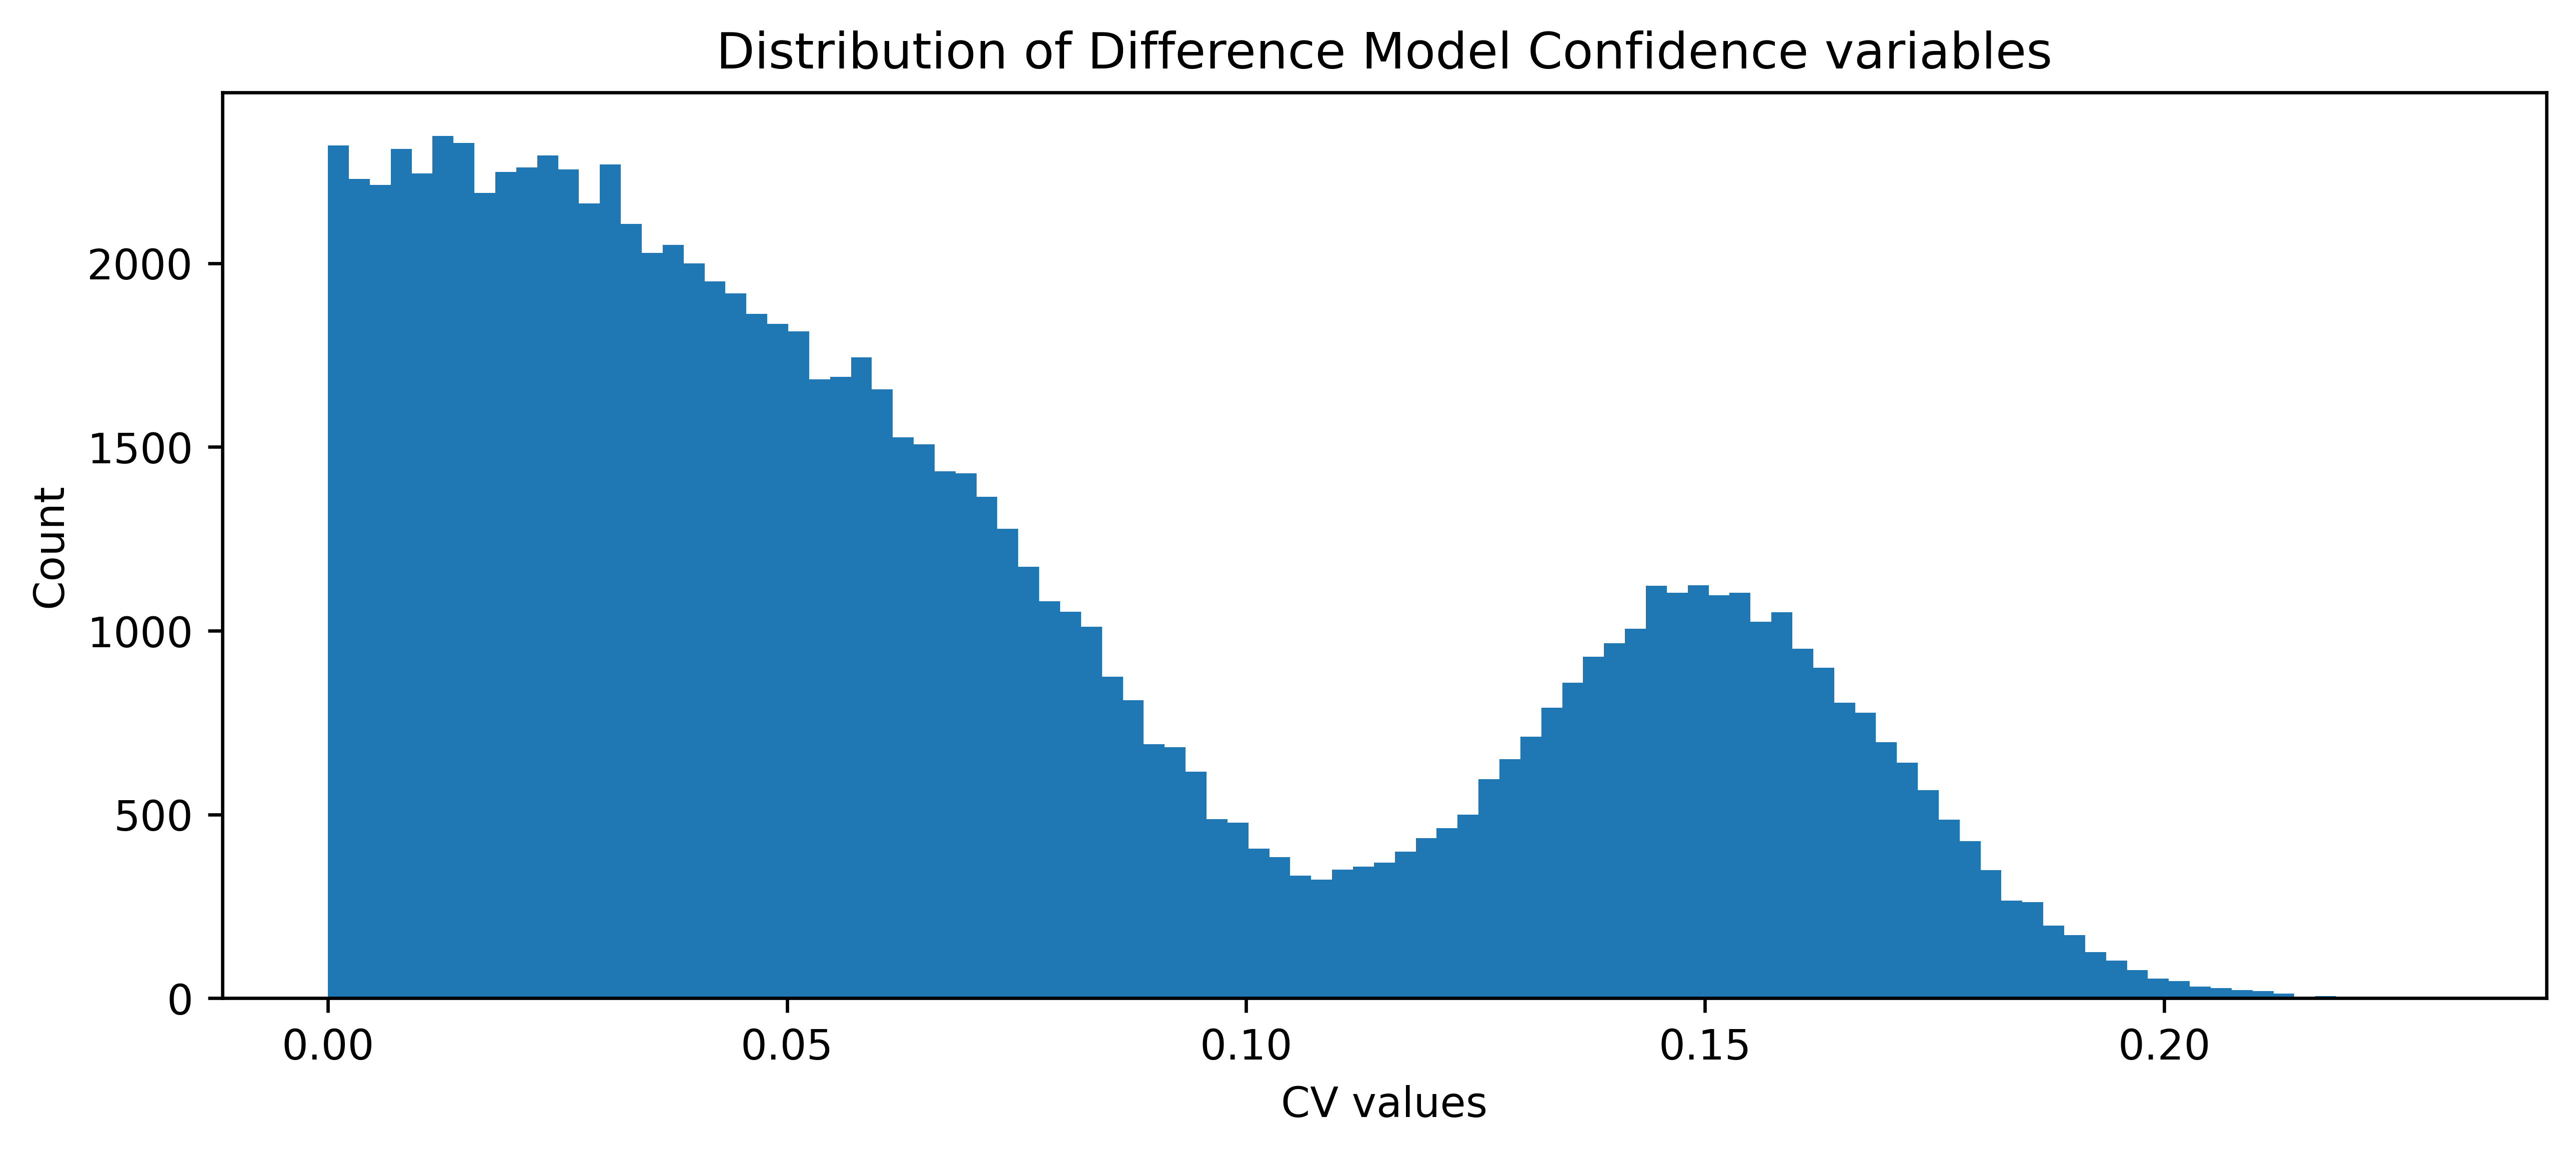

In [ ]:
print(BMDPs[5])
# print(bayesianModelBoundaries[5])
# array = bayesianDVsamples[:int(6*samples_len/6)]
a = bayesianDVsamples == 1
b = bayesianDVsamples < 0.01
print(torch.sum(b))
# c = math.log(bayesianDVsamples[:])
z = (diffCVsamples.size())
# print(z.item)
m = int(0.2* samples_len)
n = int(0.6* samples_len)
array = diffCVsamples[:]
print(b.sum()/len(b))
print(a.sum()/len(a))
array = array.numpy()
plt.figure(figsize = (10, 4), dpi = 600)
plt.hist(array, bins=101)
plt.title('Distribution of Difference Model Confidence variables')
plt.xlabel('CV values')
plt.ylabel('Count')
# plt.xticks([ 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])



torch.Size([500, 6]) torch.Size([500, 5])


Text(0, 0.5, 'Decision thresholds')

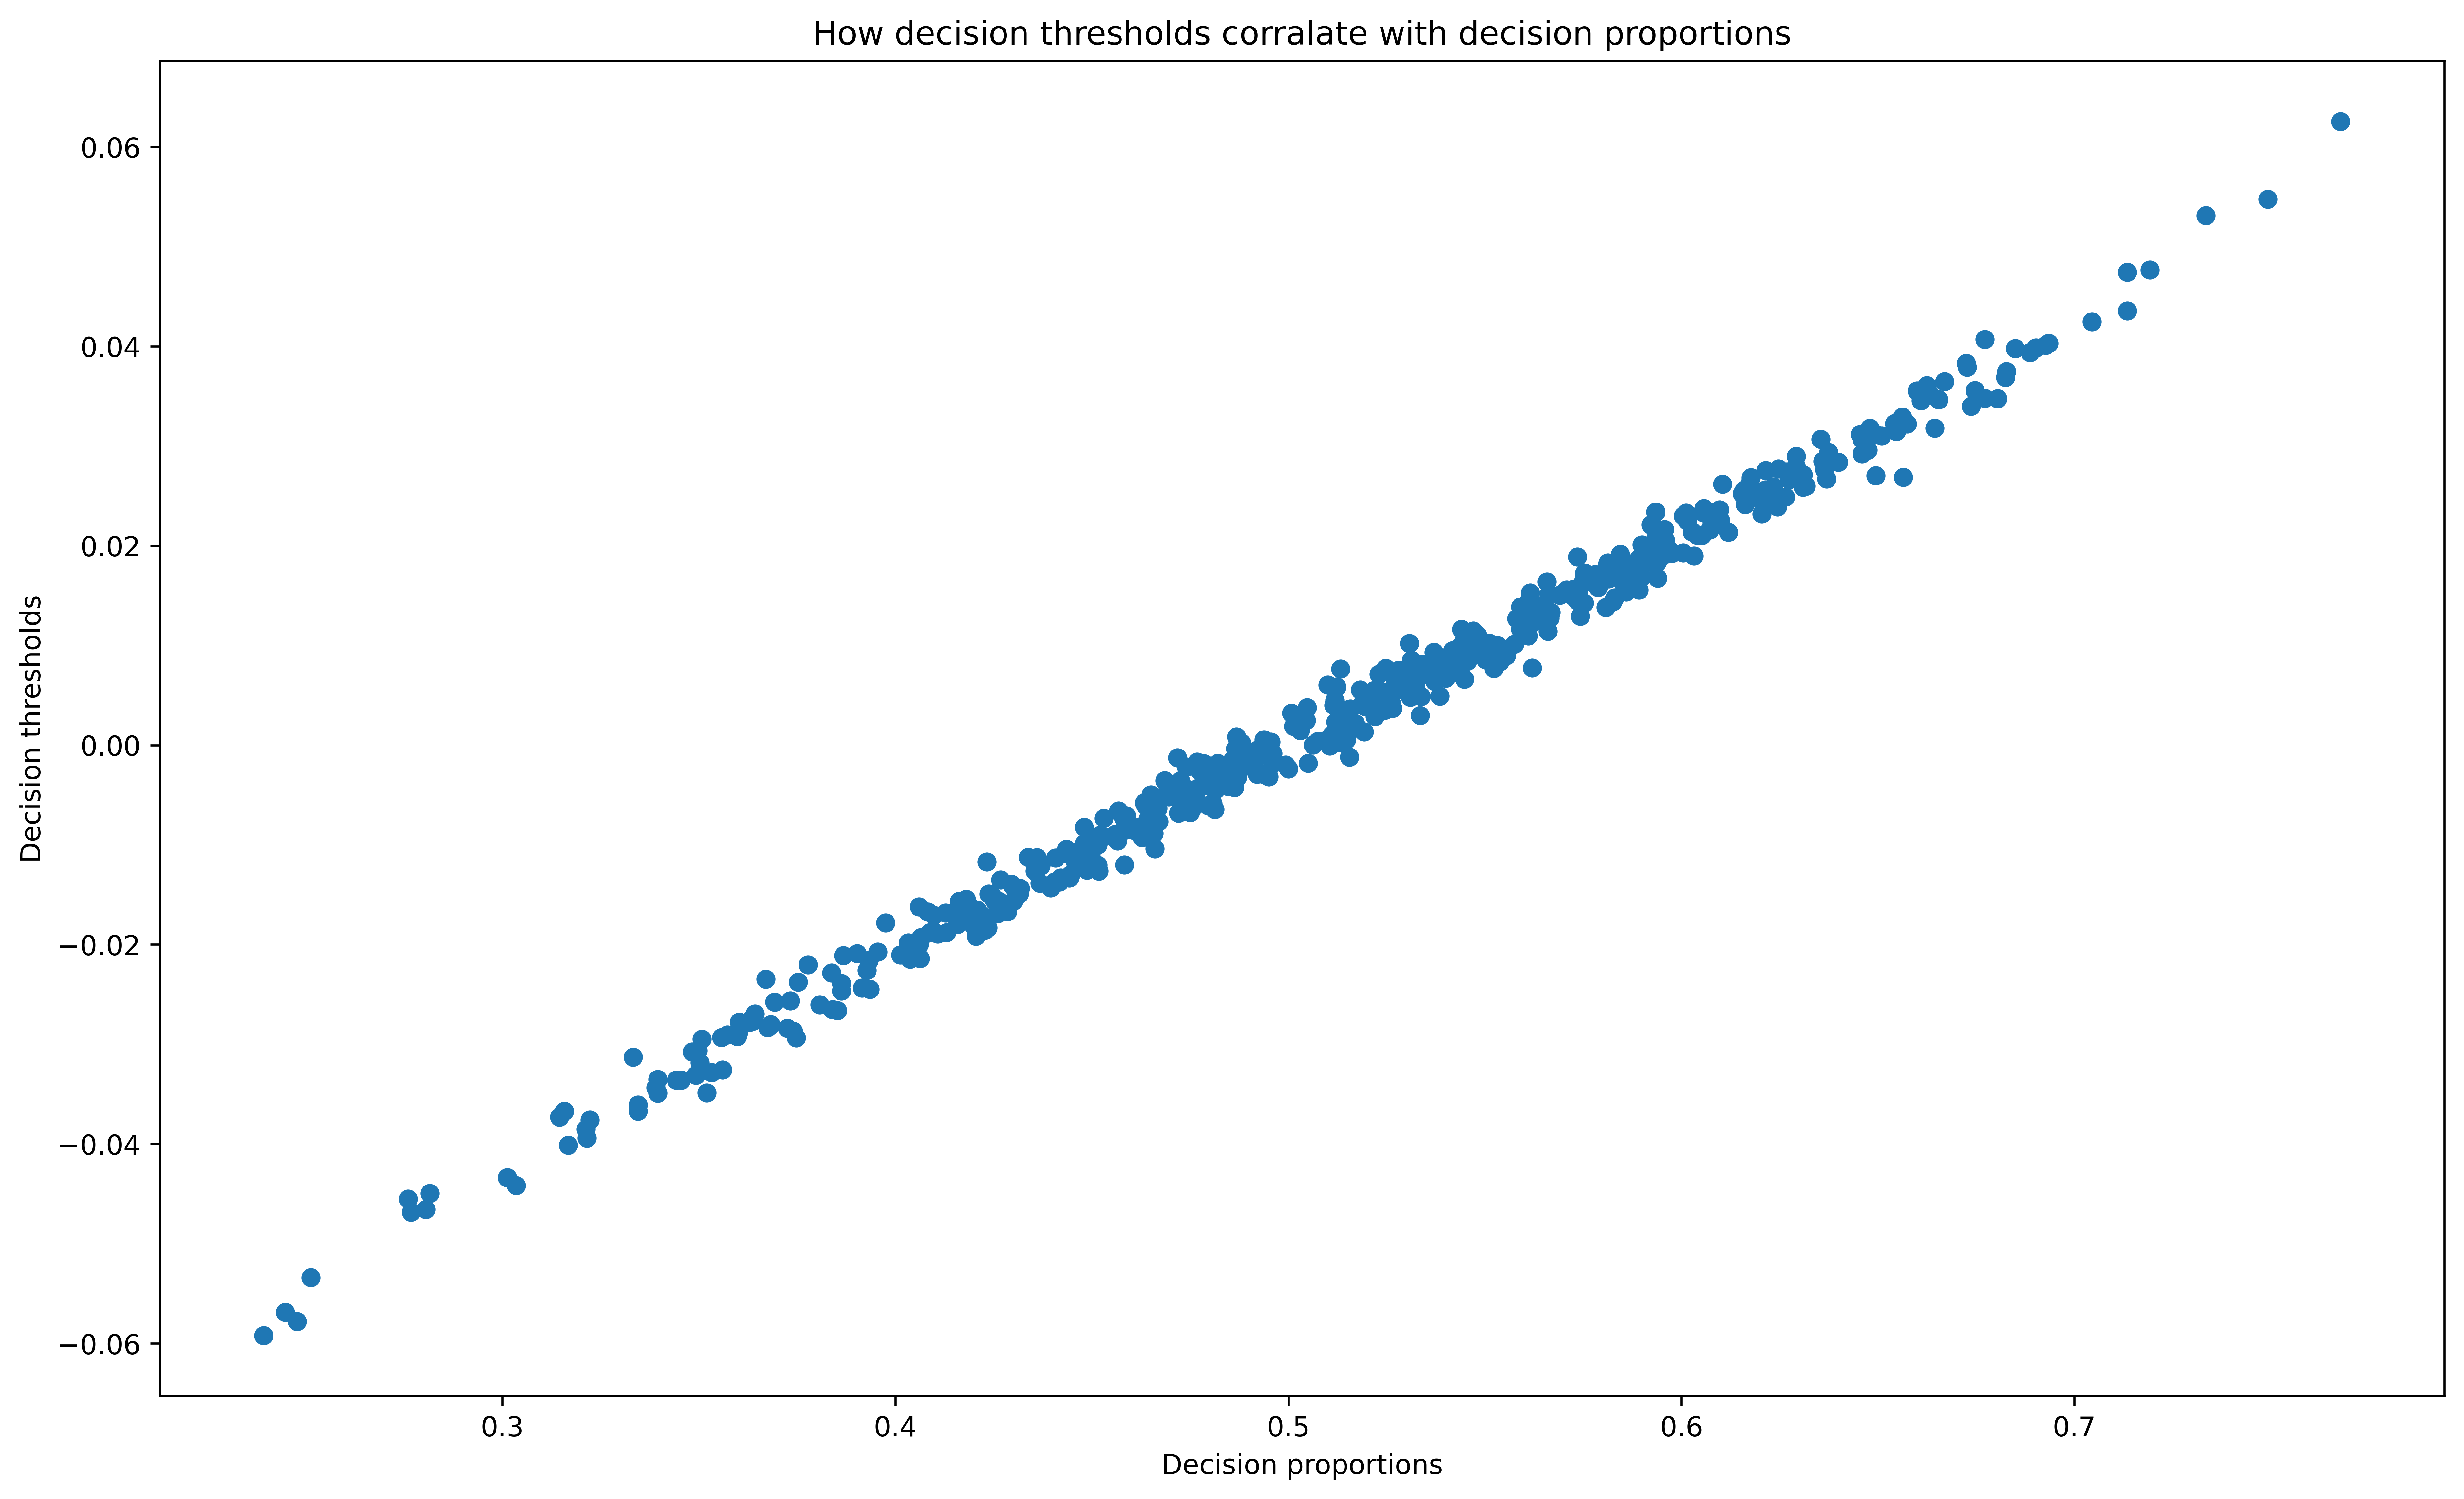

In [ ]:
# plt.scatter(BMCBs[:,0], bayesianModelCBs[0])
plt.figure(figsize = (15, 9), dpi = 600)
plt.scatter(DMDPs[:,0], diffModelBoundaries)
print(DMCPs.size(), diffModelCBs.size())
plt.title('How decision thresholds corralate with decision proportions')
plt.xlabel('Decision proportions')
plt.ylabel('Decision thresholds')


<function matplotlib.pyplot.show>

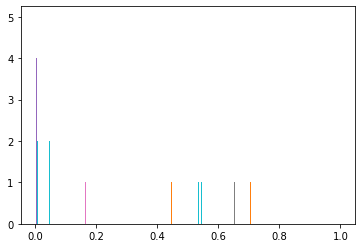

In [ ]:
plt.hist(MMCPs, 100)
plt.show

In [ ]:
diffTrain_ds = TensorDataset(DMDPs, diffModelBoundaries)
test_ds, train_ds = split(diffTrain_ds, 0.2)
pro, labs = test_ds[:]
diffModel, losses = createAndFit(500, 10, train_ds)
diffPreds = diffModel(pro)
dp = diffPreds.detach().numpy()
plt.scatter(DMDPs[:,0], diffModelBoundaries)
plt.scatter(pro[:,0], dp)
print(diffPreds[:5], labs[:5])

# def createandtestmodel(proportions, boundaries, batch_size, epochs):
#     dataset = TensorDataset(proportions, boundaries)
#     test_ds, train_ds = split(dataset, 0.2)
#     model, losses = createAndFit(epochs, batch_size, train_ds)

#     test_proportions, test_labels = test_ds[:]
#     predictions = model(test_proportions)
#     predictions = predictions.detach().numpy()
#     plt.scatter(DMDPs[:,0], diffModelBoundaries)
#     plt.scatter(pro[:,0], dp)
#     print("loss of model is: ", losses[-1])
#     return model, losses


# batch_size = 10
# epochs = 300
# diffmod, difflosses = createandtestmodel(DMDPs, diffModelBoundaries, batch_size, epochs)
# maxmod, maxlosses = createandtestmodel(MMDPs, maxModelBoundaries, batch_size, epochs)
# bayesianmod, blosses = createandtestmodel(BMDPs, diffModelBoundaries, batch_size, epochs)



# maxTrain_ds = TensorDataset(MMDPs, maxModelBoundaries)
# maxModel = createAndFitLin(100, 10, maxTrain_ds)
# maxPreds = maxModel(MMDPs)
# mp = maxPreds.detach().numpy()
# plt.scatter(MMDPs[:,0], mp)
# plt.scatter(MMDPs[:,0], maxModelBoundaries)

# bayesianTrain_ds = TensorDataset(BMDPs, bayesianModelBoundaries)
# test_ds, train_ds = split(diffTrain_ds, 0.2)
# proportions, labels = test_ds[:]
# bayesianModel = createAndFit(300, 10, train_ds)
# bayesianPreds = bayesianModel(proportions)
# bp = bayesianPreds.detach().numpy()
# plt.scatter(proportions[:,0], bp)
# plt.scatter(BMDPs[:,0], bayesianModelBoundaries)
# print(BMDPs[:])

In [ ]:
def addDBtoinput(DBs, CPs):
    inputs = torch.empty(len(DBs,),7)
    inputs[:,0] = DBs[:,0]
    inputs[:,1:] = CPs[:,:]
    return inputs

#     print(inputs[:5])
#     print(DBs[:5,0])


print(len(maxModelBoundaries))
print(len(MMCPs))
mbandcps = addDBtoinput(maxModelBoundaries, MMCPs)

print(len(maxModelCBs))

max_train_dataset = TensorDataset(mbandcps, maxModelCBs)
mtest_ds, mtrain_ds = split(max_train_dataset, 0.2)
proportions, labels = mtest_ds[:]
maxModelC, losses = createAndFitC(500, 10, mtrain_ds)
maxPreds = maxModelC(proportions)
mp = maxPreds.detach().numpy()
print(mp[:5], labels[:5])

In [ ]:
def addDBtoinput(DBs, CPs):
    inputs = torch.empty(len(DBs,),7)
    inputs[:,0] = DBs[:,0]
    inputs[:,1:] = CPs[:,:]
    return inputs

#     print(inputs[:5])
#     print(DBs[:5,0])


print(len(diffModelBoundaries))
print(len(DMCPs))
bandcps = addDBtoinput(diffModelBoundaries, DMCPs)

print(len(diffModelCBs))

diff_train_dataset = TensorDataset(bandcps, diffModelCBs)
test_ds, train_ds = split(diff_train_dataset, 0.2)
proportions, labels = test_ds[:]
diffModelC, losses = createAndFitC(500, 10, train_ds)
diffPreds = diffModelC(proportions)
dp = diffPreds.detach().numpy()
print(dp[:5], labels[:5])

# extra work

## joint model

In [ ]:
z = 384
# print(DMDPs[z])
# print(DMCPs[z])
combinedProportions = combineProportions(DMDPs, DMCPs)
print(diffModelBoundaries[z])
print(diffModelCBs[z])
combinedBoundaries = combineBoundaries(diffModelBoundaries, diffModelCBs)
# print(combinedProportions.size())
# print(combinedBoundaries.size())
diff_train_ds = TensorDataset(combinedProportions, combinedBoundaries)
# print(diff_train_ds[z])

diff_joint_model, diff_joint_losses = createAndFitJ(500, 10, diff_train_ds)



tensor([-0.0093])
tensor([0.0036, 0.0183, 0.1062, 0.1223, 0.1607])
Epoch [99/500], validation Loss: 0.000060167
Epoch [199/500], validation Loss: 0.000046131
Epoch [299/500], validation Loss: 0.000039511
Epoch [399/500], validation Loss: 0.000039374
Epoch [499/500], validation Loss: 0.000033902
fitted


In [ ]:
print(combinedBoundaries[:10])
diff_joint_model(combinedProportions[:10])

tensor([[-0.0015,  0.0195,  0.0212,  0.0597,  0.0777,  0.0875],
        [-0.0243,  0.0153,  0.0223,  0.0860,  0.1002,  0.2047],
        [ 0.0333,  0.0198,  0.0877,  0.1124,  0.1689,  0.2015],
        [ 0.0299,  0.0199,  0.0592,  0.0758,  0.1725,  0.1982],
        [ 0.0228,  0.0589,  0.1352,  0.1422,  0.1541,  0.1844],
        [-0.0040,  0.0500,  0.0524,  0.0836,  0.1068,  0.1404],
        [ 0.0215,  0.0801,  0.0820,  0.1067,  0.1406,  0.2000],
        [ 0.0306,  0.0872,  0.0969,  0.1114,  0.1557,  0.1707],
        [-0.0031,  0.0133,  0.0565,  0.1107,  0.1122,  0.1703],
        [-0.0058,  0.0013,  0.0113,  0.0785,  0.1390,  0.1789]])


tensor([[ 0.0026,  0.0146,  0.0083,  0.0605,  0.0784,  0.0823],
        [-0.0251,  0.0150,  0.0159,  0.0905,  0.0999,  0.1920],
        [ 0.0311,  0.0266,  0.0908,  0.1131,  0.1654,  0.1981],
        [ 0.0300,  0.0228,  0.0661,  0.0889,  0.1691,  0.1922],
        [ 0.0245,  0.0627,  0.1248,  0.1372,  0.1521,  0.1851],
        [-0.0092,  0.0507,  0.0540,  0.0928,  0.1142,  0.1389],
        [ 0.0201,  0.0905,  0.0914,  0.1124,  0.1428,  0.1924],
        [ 0.0290,  0.0896,  0.1035,  0.1204,  0.1598,  0.1781],
        [-0.0009,  0.0083,  0.0660,  0.1130,  0.1183,  0.1786],
        [-0.0093, -0.0015, -0.0027,  0.0849,  0.1341,  0.1872]],
       grad_fn=<AddmmBackward0>)

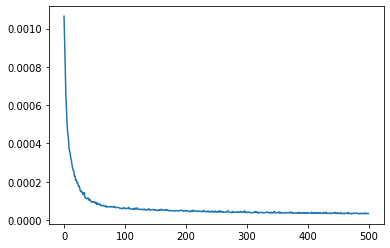

In [ ]:
plt.plot(diff_joint_losses)